In [19]:
# @title
# =============================================================
# CÉLULA 1: IMPORTAR BIBLIOTECAS E FAZER UPLOAD DOS ARQUIVOS
# =============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# Configurações de estilo
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("="*60)
print("ANÁLISE DE MÚLTIPLOS ARQUIVOS CLASSIFICADOS")
print("="*60)

# Fazer upload dos arquivos
print("\n📁 FAZENDO UPLOAD DOS ARQUIVOS...")
print("Selecione todos os arquivos TXT classificados")
uploaded = files.upload()

# Listar arquivos carregados
txt_files = [f for f in uploaded.keys() if f.endswith('.txt')]
print(f"\n✅ {len(txt_files)} arquivo(s) carregado(s):")
for f in txt_files:
    print(f"   • {f}")

ANÁLISE DE MÚLTIPLOS ARQUIVOS CLASSIFICADOS

📁 FAZENDO UPLOAD DOS ARQUIVOS...
Selecione todos os arquivos TXT classificados


Saving 1.txt to 1 (1).txt
Saving 2.txt to 2 (1).txt
Saving 3.txt to 3 (1).txt
Saving 4.txt to 4 (1).txt
Saving 5.txt to 5 (1).txt
Saving 6.txt to 6 (1).txt
Saving 7.txt to 7 (1).txt
Saving 8.txt to 8 (1).txt
Saving 9.txt to 9 (1).txt
Saving 10.txt to 10 (1).txt
Saving 11.txt to 11 (1).txt
Saving 12.txt to 12 (1).txt
Saving 13.txt to 13 (1).txt
Saving 14.txt to 14 (1).txt
Saving 15.txt to 15 (1).txt
Saving 16.txt to 16 (1).txt
Saving 17.txt to 17 (1).txt
Saving 18.txt to 18 (1).txt
Saving 19.txt to 19 (1).txt
Saving 20.txt to 20 (1).txt

✅ 20 arquivo(s) carregado(s):
   • 1 (1).txt
   • 2 (1).txt
   • 3 (1).txt
   • 4 (1).txt
   • 5 (1).txt
   • 6 (1).txt
   • 7 (1).txt
   • 8 (1).txt
   • 9 (1).txt
   • 10 (1).txt
   • 11 (1).txt
   • 12 (1).txt
   • 13 (1).txt
   • 14 (1).txt
   • 15 (1).txt
   • 16 (1).txt
   • 17 (1).txt
   • 18 (1).txt
   • 19 (1).txt
   • 20 (1).txt


In [20]:
# @title
# =============================================================
# CÉLULA 2: FUNÇÕES PARA PROCESSAMENTO DOS DADOS
# =============================================================

def timestamp_to_seconds(timestamp):
    """Converte timestamp para segundos"""
    try:
        timestamp = timestamp.strip()
        if ',' in timestamp:
            time_part, ms = timestamp.split(',')
            ms = float('0.' + ms)
        else:
            time_part = timestamp
            ms = 0

        if len(time_part.split(':')) == 3:
            h, m, s = time_part.split(':')
            return int(h) * 3600 + int(m) * 60 + int(s) + ms
        else:
            return 0
    except:
        return 0

def parse_classified_file(filename, file_content):
    """Lê um arquivo TXT já classificado com sentimentos"""
    if isinstance(file_content, bytes):
        content = file_content.decode('utf-8')
    else:
        content = str(file_content)

    lines = content.split('\n')

    blocks_data = []
    current_block = {}
    text_lines = []

    for line in lines:
        stripped = line.strip()

        # Linha vazia indica fim do bloco
        if stripped == '' and current_block:
            if text_lines:
                current_block['text'] = ' '.join(text_lines)

            if 'sentiment' in current_block and 'start_time' in current_block:
                current_block['start_seconds'] = timestamp_to_seconds(current_block['start_time'])
                current_block['end_seconds'] = timestamp_to_seconds(current_block['end_time'])
                current_block['duration'] = current_block['end_seconds'] - current_block['start_seconds']
                current_block['text_length'] = len(current_block.get('text', ''))
                current_block['file_name'] = filename

                blocks_data.append(current_block)

            current_block = {}
            text_lines = []
            continue

        # Número da sequência
        if re.match(r'^\d+$', stripped):
            current_block['sequence'] = stripped

        # Timestamp
        elif '-->' in stripped:
            parts = stripped.split('-->')
            if len(parts) == 2:
                current_block['start_time'] = parts[0].strip()
                current_block['end_time'] = parts[1].strip()

        # Sentimento
        elif stripped in ['[Positive]', '[Negative]', '[Neutral]']:
            current_block['sentiment'] = stripped[1:-1]

        # Texto
        elif (stripped and not re.match(r'^\d+$', stripped)
              and '-->' not in stripped
              and not stripped.startswith('[')):
            text_lines.append(stripped)

    return pd.DataFrame(blocks_data)

In [21]:
# @title
# =============================================================
# CÉLULA 3: PROCESSAR TODOS OS ARQUIVOS
# =============================================================
print("\n📊 PROCESSANDO ARQUIVOS...")

all_dataframes = []
for filename, content in uploaded.items():
    if filename.endswith('.txt'):
        print(f"  Processando: {filename}")
        df_file = parse_classified_file(filename, content)

        if not df_file.empty:
            all_dataframes.append(df_file)
            print(f"    ✅ {len(df_file)} blocos encontrados")
        else:
            print(f"    ⚠️  Nenhum bloco válido")

# Combinar dados
if all_dataframes:
    df_combined = pd.concat(all_dataframes, ignore_index=True)

    # Adicionar colunas numéricas
    sentiment_map_num = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    df_combined['sentiment_numeric'] = df_combined['sentiment'].map(sentiment_map_num)
    df_combined['minute'] = (df_combined['start_seconds'] // 60).astype(int)

    print(f"\n✅ DADOS COMBINADOS:")
    print(f"   Total de blocos: {len(df_combined)}")
    print(f"   Total de arquivos: {df_combined['file_name'].nunique()}")
    print(f"   Duração total: {df_combined['duration'].sum():.1f} segundos")

    # Mostrar preview
    print("\n📋 PREVIEW DOS DADOS (5 primeiras linhas):")
    print(df_combined.head().to_string())

    # Estatísticas gerais
    print("\n📊 ESTATÍSTICAS GERAIS DE SENTIMENTOS:")
    sentiment_stats = df_combined['sentiment'].value_counts()
    total = len(df_combined)
    for sentiment, count in sentiment_stats.items():
        percentage = (count / total) * 100
        print(f"   {sentiment}: {count} blocos ({percentage:.1f}%)")

    # Resultado final da célula
    print("\n" + "="*60)
    print(f"RESULTADO: {len(df_combined)} blocos processados de {df_combined['file_name'].nunique()} arquivos")
    print("="*60)
else:
    print("❌ Nenhum dado válido encontrado!")
    df_combined = pd.DataFrame()


📊 PROCESSANDO ARQUIVOS...
  Processando: 1 (1).txt
    ✅ 111 blocos encontrados
  Processando: 2 (1).txt
    ✅ 118 blocos encontrados
  Processando: 3 (1).txt
    ✅ 180 blocos encontrados
  Processando: 4 (1).txt
    ✅ 95 blocos encontrados
  Processando: 5 (1).txt
    ✅ 98 blocos encontrados
  Processando: 6 (1).txt
    ✅ 203 blocos encontrados
  Processando: 7 (1).txt
    ✅ 287 blocos encontrados
  Processando: 8 (1).txt
    ✅ 142 blocos encontrados
  Processando: 9 (1).txt
    ✅ 85 blocos encontrados
  Processando: 10 (1).txt
    ✅ 95 blocos encontrados
  Processando: 11 (1).txt
    ✅ 67 blocos encontrados
  Processando: 12 (1).txt
    ✅ 228 blocos encontrados
  Processando: 13 (1).txt
    ✅ 58 blocos encontrados
  Processando: 14 (1).txt
    ✅ 96 blocos encontrados
  Processando: 15 (1).txt
    ✅ 79 blocos encontrados
  Processando: 16 (1).txt
    ✅ 62 blocos encontrados
  Processando: 17 (1).txt
    ✅ 58 blocos encontrados
  Processando: 18 (1).txt
    ✅ 72 blocos encontrados
  P


🎨 GERANDO GRÁFICO 1: Distribuição Geral


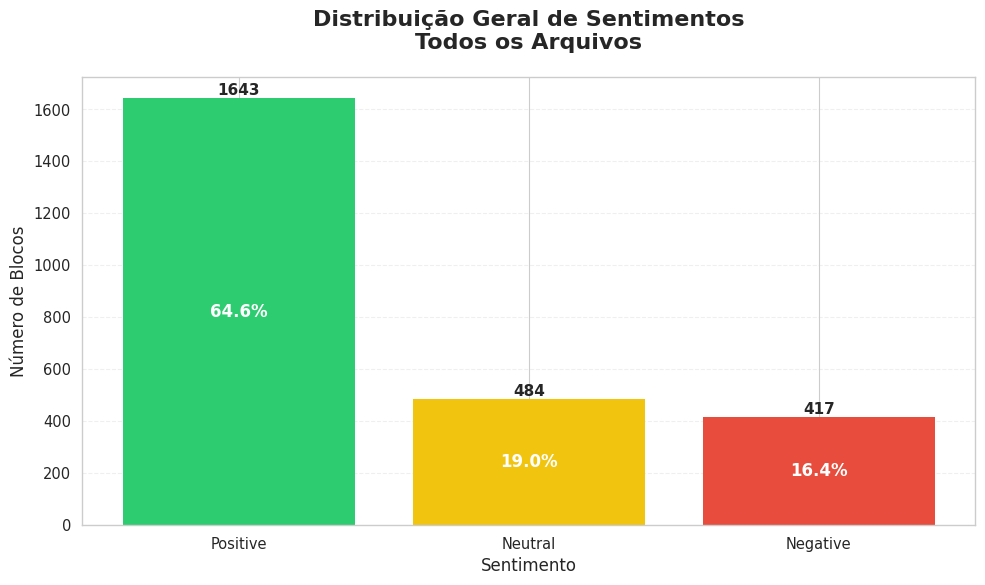


📊 RESULTADOS DA DISTRIBUIÇÃO GERAL:
   Positive: 1643 blocos (64.6%)
   Neutral: 484 blocos (19.0%)
   Negative: 417 blocos (16.4%)

✅ Gráfico 1 salvo: grafico1_distribuicao_geral.png
   Arquivo: 2544 blocos analisados
   Predominante: Positive (64.6%)


In [22]:
# @title
# =============================================================
# CÉLULA 4: GRÁFICO 1 - DISTRIBUIÇÃO GERAL DE SENTIMENTOS
# =============================================================
print("\n🎨 GERANDO GRÁFICO 1: Distribuição Geral")

if not df_combined.empty:
    plt.figure(figsize=(10, 6))

    colors = {'Positive': '#2ecc71', 'Neutral': '#f1c40f', 'Negative': '#e74c3c'}
    sentiment_counts = df_combined['sentiment'].value_counts()

    bars = plt.bar(sentiment_counts.index,
                   sentiment_counts.values,
                   color=[colors[s] for s in sentiment_counts.index],
                   edgecolor='black',
                   linewidth=0)

    plt.title('Distribuição Geral de Sentimentos\nTodos os Arquivos',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Sentimento', fontsize=12)
    plt.ylabel('Número de Blocos', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Adicionar valores
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    # Adicionar porcentagem
    total = len(df_combined)
    for i, (sentiment, count) in enumerate(sentiment_counts.items()):
        percentage = (count / total) * 100
        plt.text(i, count/2, f'{percentage:.1f}%',
                ha='center', va='center',
                fontsize=12, fontweight='bold', color='white')

    plt.tight_layout()
    plt.savefig('grafico1_distribuicao_geral.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Resultados numéricos
    print("\n📊 RESULTADOS DA DISTRIBUIÇÃO GERAL:")
    total = len(df_combined)
    for sentiment, count in sentiment_counts.items():
        percentage = (count / total) * 100
        print(f"   {sentiment}: {count} blocos ({percentage:.1f}%)")

    print(f"\n✅ Gráfico 1 salvo: grafico1_distribuicao_geral.png")
    print(f"   Arquivo: {len(df_combined)} blocos analisados")
    print(f"   Predominante: {sentiment_counts.index[0]} ({sentiment_counts.iloc[0]/total*100:.1f}%)")
else:
    print("❌ Nenhum dado para gerar gráfico")


🎨 GERANDO GRÁFICO 2: Distribuição por Arquivo

📊 ESTATÍSTICAS POR ARQUIVO:

   📄 1 (1).txt:
      Total: 111 blocos
      Positive: 70 (63.1%)
      Neutral: 14 (12.6%)
      Negative: 27 (24.3%)

   📄 10 (1).txt:
      Total: 95 blocos
      Positive: 60 (63.2%)
      Neutral: 20 (21.1%)
      Negative: 15 (15.8%)

   📄 11 (1).txt:
      Total: 67 blocos
      Positive: 44 (65.7%)
      Neutral: 10 (14.9%)
      Negative: 13 (19.4%)

   📄 12 (1).txt:
      Total: 228 blocos
      Positive: 137 (60.1%)
      Neutral: 55 (24.1%)
      Negative: 36 (15.8%)

   📄 13 (1).txt:
      Total: 58 blocos
      Positive: 43 (74.1%)
      Neutral: 8 (13.8%)
      Negative: 7 (12.1%)

   📄 14 (1).txt:
      Total: 96 blocos
      Positive: 56 (58.3%)
      Neutral: 31 (32.3%)
      Negative: 9 (9.4%)

   📄 15 (1).txt:
      Total: 79 blocos
      Positive: 54 (68.4%)
      Neutral: 19 (24.1%)
      Negative: 6 (7.6%)

   📄 16 (1).txt:
      Total: 62 blocos
      Positive: 42 (67.7%)
      Neutral

<Figure size 1200x800 with 0 Axes>

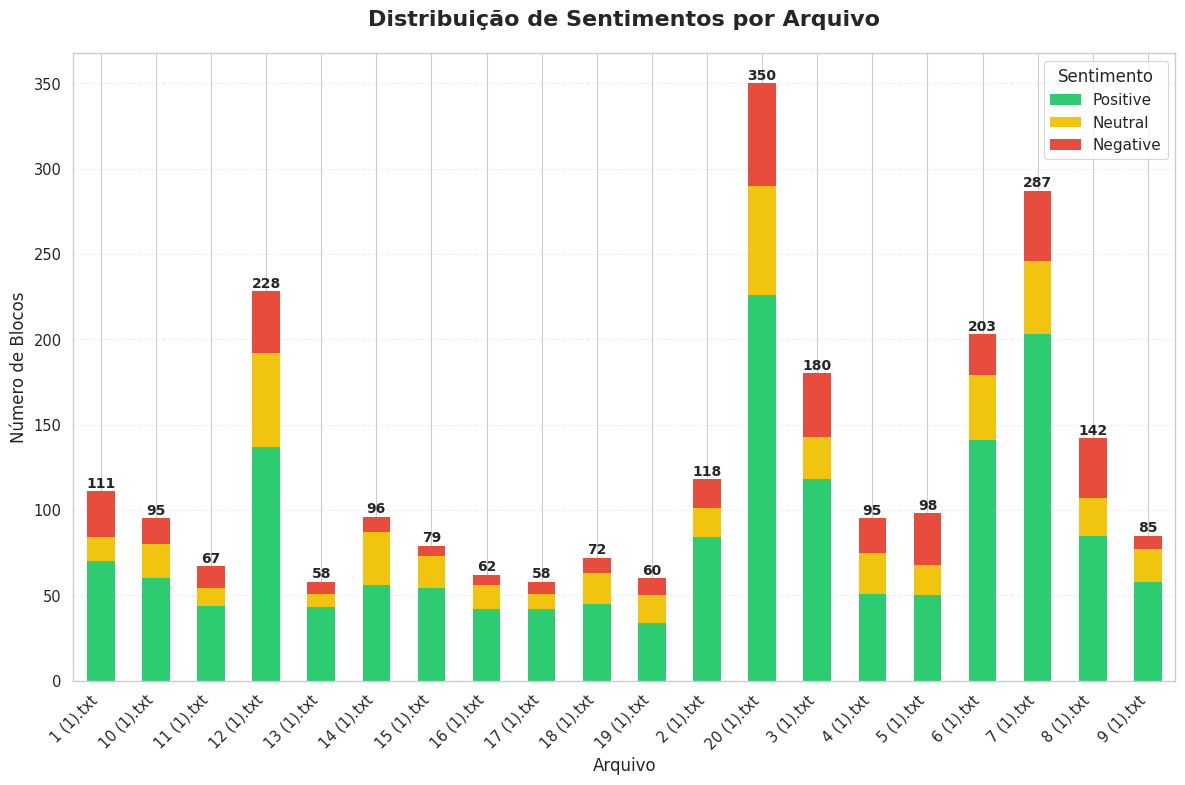


📈 ARQUIVO MAIS POSITIVO: 13 (1).txt (score: 0.621)
📉 ARQUIVO MAIS NEGATIVO: 5 (1).txt (score: 0.204)

✅ Gráfico 2 salvo: grafico2_distribuicao_por_arquivo.png
   Total de arquivos: 20
   Total de blocos: 2544


In [23]:
# @title
# =============================================================
# CÉLULA 5: GRÁFICO 2 - DISTRIBUIÇÃO POR ARQUIVO
# =============================================================
print("\n🎨 GERANDO GRÁFICO 2: Distribuição por Arquivo")

if not df_combined.empty and df_combined['file_name'].nunique() > 1:
    plt.figure(figsize=(12, 8))

    # Criar tabela cruzada
    sentiment_by_file = pd.crosstab(df_combined['file_name'], df_combined['sentiment'])
    sentiment_by_file = sentiment_by_file[['Positive', 'Neutral', 'Negative']]

    # Calcular estatísticas por arquivo
    print("\n📊 ESTATÍSTICAS POR ARQUIVO:")
    file_stats = []
    for file_name in sorted(sentiment_by_file.index):
        row = sentiment_by_file.loc[file_name]
        total = row.sum()
        pos_pct = (row['Positive'] / total * 100) if total > 0 else 0
        neu_pct = (row['Neutral'] / total * 100) if total > 0 else 0
        neg_pct = (row['Negative'] / total * 100) if total > 0 else 0
        file_stats.append({
            'Arquivo': file_name,
            'Total': total,
            'Positive': f"{row['Positive']} ({pos_pct:.1f}%)",
            'Neutral': f"{row['Neutral']} ({neu_pct:.1f}%)",
            'Negative': f"{row['Negative']} ({neg_pct:.1f}%)"
        })

    # Imprimir estatísticas
    for stat in file_stats:
        print(f"\n   📄 {stat['Arquivo']}:")
        print(f"      Total: {stat['Total']} blocos")
        print(f"      Positive: {stat['Positive']}")
        print(f"      Neutral: {stat['Neutral']}")
        print(f"      Negative: {stat['Negative']}")

    # Plot
    ax = sentiment_by_file.plot(kind='bar',
                                stacked=True,
                                color=['#2ecc71', '#f1c40f', '#e74c3c'],
                                figsize=(12, 8),
                                edgecolor='black',
                                linewidth=0)

    plt.title('Distribuição de Sentimentos por Arquivo',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Arquivo', fontsize=12)
    plt.ylabel('Número de Blocos', fontsize=12)
    plt.legend(title='Sentimento', title_fontsize=12, fontsize=11)
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Adicionar totais
    totals = sentiment_by_file.sum(axis=1)
    for i, total in enumerate(totals):
        plt.text(i, total + 0.5, str(total),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('grafico2_distribuicao_por_arquivo.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Arquivo mais positivo
    positivity_scores = []
    for file_name in sentiment_by_file.index:
        row = sentiment_by_file.loc[file_name]
        total = row.sum()
        if total > 0:
            positivity = (row['Positive'] - row['Negative']) / total
            positivity_scores.append((file_name, positivity))

    if positivity_scores:
        most_positive = max(positivity_scores, key=lambda x: x[1])
        least_positive = min(positivity_scores, key=lambda x: x[1])
        print(f"\n📈 ARQUIVO MAIS POSITIVO: {most_positive[0]} (score: {most_positive[1]:.3f})")
        print(f"📉 ARQUIVO MAIS NEGATIVO: {least_positive[0]} (score: {least_positive[1]:.3f})")

    print(f"\n✅ Gráfico 2 salvo: grafico2_distribuicao_por_arquivo.png")
    print(f"   Total de arquivos: {len(sentiment_by_file)}")
    print(f"   Total de blocos: {totals.sum()}")
elif df_combined['file_name'].nunique() == 1:
    print("⚠️  Apenas um arquivo encontrado. Gráfico não gerado.")
    print(f"   Arquivo único: {df_combined['file_name'].iloc[0]}")
    print(f"   Blocos no arquivo: {len(df_combined)}")
else:
    print("❌ Nenhum dado para gerar gráfico")


GERANDO GRÁFICO 3: Evolução Temporal dos Sentimentos (Versão Corrigida)

ESTATÍSTICAS TEMPORAIS:
   Duração total: 19.5 minutos (1170 segundos)
   Total de blocos: 2544
   Sentimento médio geral: 0.482


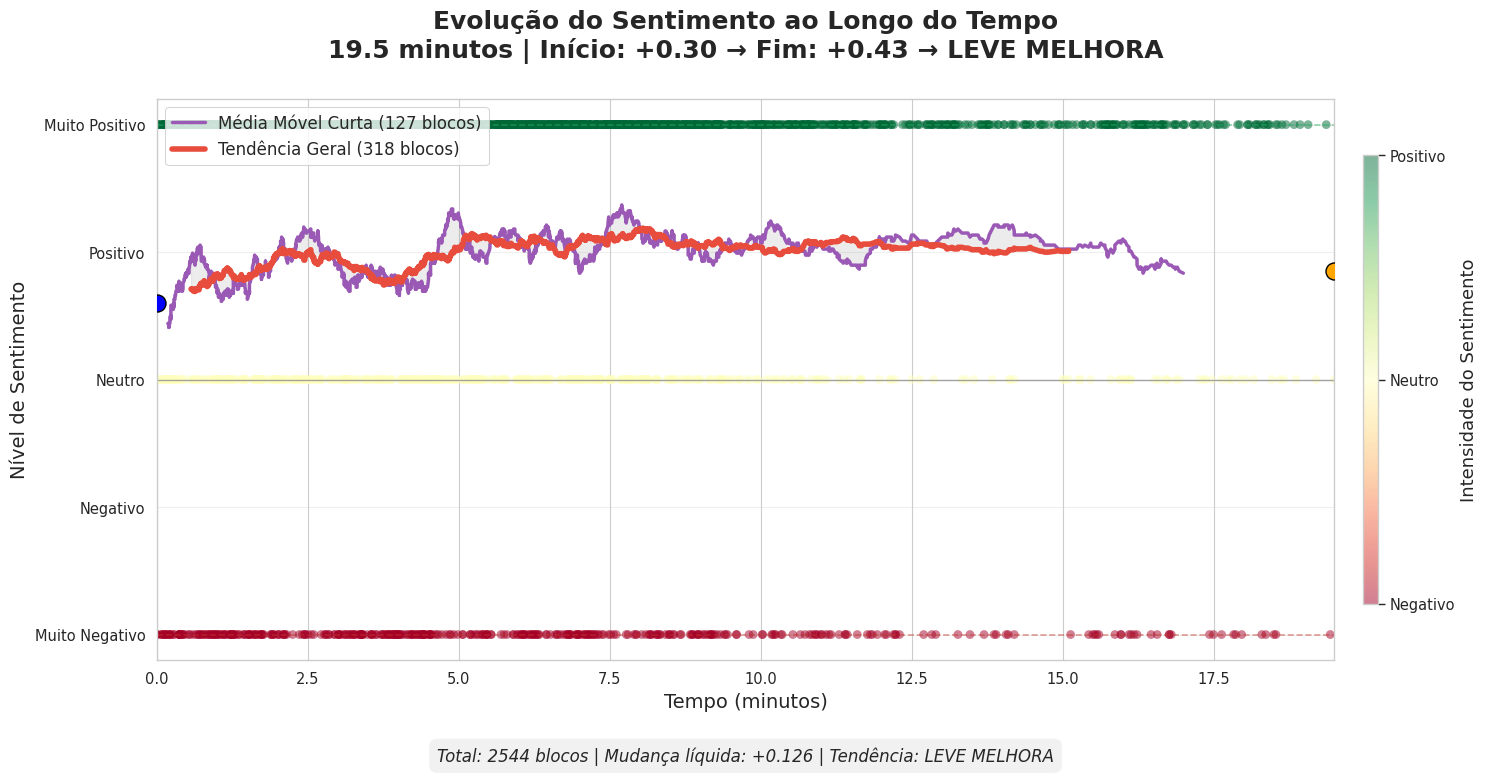


ANÁLISE FINAL:
   Sentimento inicial: +0.302
   Sentimento final:    +0.428
   Mudança total:       +0.126 → LEVE MELHORA

Gráfico salvo como: grafico3_evolucao_temporal_final.png


In [25]:
# @title
# =============================================================
# CÉLULA 6: GRÁFICO 3 - EVOLUÇÃO TEMPORAL DOS SENTIMENTOS (VERSÃO CORRIGIDA E FINAL)
# =============================================================
print("\nGERANDO GRÁFICO 3: Evolução Temporal dos Sentimentos (Versão Corrigida)")

if df_combined.empty:
    print("Nenhum dado para gerar gráfico")
else:
    # Preparar dados
    df = df_combined.sort_values('start_seconds').copy()
    df['time_min'] = df['start_seconds'] / 60
    total_minutes = df['time_min'].max()

    print(f"\nESTATÍSTICAS TEMPORAIS:")
    print(f"   Duração total: {total_minutes:.1f} minutos ({df['start_seconds'].max():.0f} segundos)")
    print(f"   Total de blocos: {len(df)}")
    print(f"   Sentimento médio geral: {df['sentiment_numeric'].mean():.3f}")

    # ==========================
    # GRÁFICO
    # ==========================
    fig, ax = plt.subplots(figsize=(16, 8))

    # Pontos individuais (leve transparência)
    scatter = ax.scatter(df['time_min'], df['sentiment_numeric'],
                         c=df['sentiment_numeric'], cmap='RdYlGn',
                         alpha=0.5, s=40, edgecolors='none', zorder=2)

    # Médias móveis
    window_short = max(5, len(df) // 20)
    window_long  = max(15, len(df) // 8)

    ma_short = df['sentiment_numeric'].rolling(window=window_short, center=True).mean()
    ma_long  = df['sentiment_numeric'].rolling(window=window_long,  center=True).mean()

    ax.plot(df['time_min'], ma_short, color='#9b59b6', linewidth=2.5,
            label=f'Média Móvel Curta ({window_short} blocos)')
    ax.plot(df['time_min'], ma_long,  color='#e74c3c', linewidth=4,
            label=f'Tendência Geral ({window_long} blocos)')

    # Área entre as médias (visualização de volatilidade)
    ax.fill_between(df['time_min'], ma_short, ma_long,
                    color='gray', alpha=0.15)

    # Linhas de referência
    ax.axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.7)
    ax.axhline(1, color='#27ae60', linestyle='--', alpha=0.5)
    ax.axhline(-1, color='#c0392b', linestyle='--', alpha=0.5)

    # Marcações início e fim
    inicio = df['sentiment_numeric'].iloc[:window_long//2].mean()
    fim    = df['sentiment_numeric'].iloc[-window_long//2:].mean()
    ax.scatter(0, inicio, color='blue', s=150, zorder=5, edgecolor='black', linewidth=1)
    ax.scatter(total_minutes, fim, color='orange', s=150, zorder=5, edgecolor='black', linewidth=1)

    # ==========================
    # ESTILIZAÇÃO
    # ==========================
    delta = fim - inicio
    tendencia = "MELHOROU" if delta > 0.15 else "LEVE MELHORA" if delta > 0.05 else \
                "PIOROU" if delta < -0.15 else "LEVE QUEDA" if delta < -0.05 else "ESTÁVEL"

    ax.set_title(f'Evolução do Sentimento ao Longo do Tempo\n'
                 f'{total_minutes:.1f} minutos | Início: {inicio:+.2f} → Fim: {fim:+.2f} → {tendencia}',
                 fontsize=18, fontweight='bold', pad=30)

    ax.set_xlabel('Tempo (minutos)', fontsize=14)
    ax.set_ylabel('Nível de Sentimento', fontsize=14)

    ax.set_xlim(0, total_minutes)
    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_yticklabels(['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo'])

    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=12, loc='upper left')

    # ==========================
    # COLORBAR CORRIGIDA (agora funciona!)
    # ==========================
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=30, pad=0.02)
    cbar.set_label('Intensidade do Sentimento', fontsize=13)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(['Negativo', 'Neutro', 'Positivo'])

    # Rodapé com resumo
    ax.text(0.5, -0.18,
            f"Total: {len(df)} blocos | Mudança líquida: {delta:+.3f} | Tendência: {tendencia}",
            transform=ax.transAxes, ha='center', fontsize=12, style='italic',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="#f0f0f0", alpha=0.9))

    plt.tight_layout()
    plt.savefig('grafico3_evolucao_temporal_final.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ==========================
    # RESUMO NO CONSOLE
    # ==========================
    print(f"\nANÁLISE FINAL:")
    print(f"   Sentimento inicial: {inicio:+.3f}")
    print(f"   Sentimento final:    {fim:+.3f}")
    print(f"   Mudança total:       {delta:+.3f} → {tendencia}")
    print(f"\nGráfico salvo como: grafico3_evolucao_temporal_final.png")


📊 GERANDO GRÁFICO 4: Evolução Temporal - Todas as Classes

🎯 CLASSES DE SENTIMENTO ENCONTRADAS: ['Positive', 'Neutral', 'Negative']
🎨 MAPEAMENTO DE CORES:
   Positive: #2ecc71
   Neutral: #f1c40f
   Negative: #e74c3c

📈 ESTATÍSTICAS DETALHADAS:
   Duração total: 19.5 minutos
   Resolução temporal: 1 minutos por intervalo
   Número de intervalos: 20

📊 DISTRIBUIÇÃO POR CLASSE:
   Positive: 1643 blocos (64.6%)
   Neutral: 484 blocos (19.0%)
   Negative: 417 blocos (16.4%)

🎭 DIVERSIDADE TEMPORAL:
   Média do índice de diversidade: 0.268
   🎯 Baixa diversidade (uma classe dominante)


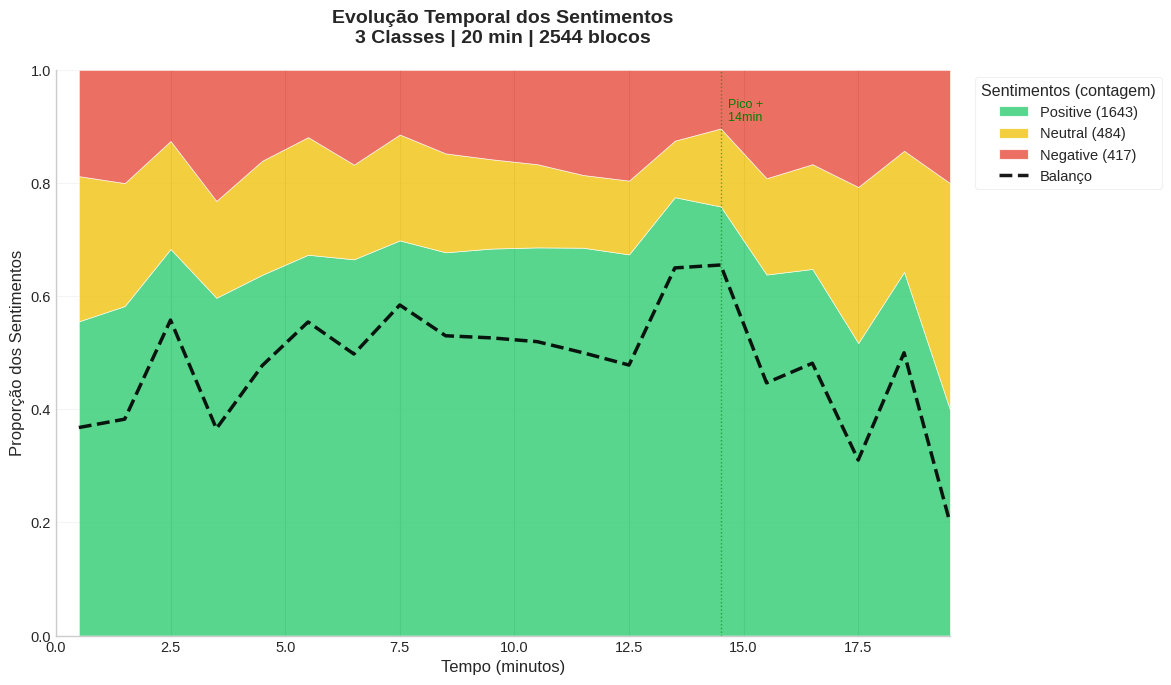


✅ Gráfico salvo: grafico4_todas_classes.png
   Classes representadas: Positive, Neutral, Negative
   Cores utilizadas: Positive:#2ecc71, Neutral:#f1c40f, Negative:#e74c3c


In [26]:
# @title
# =============================================================
# CÉLULA 7: GRÁFICO 4 - EVOLUÇÃO TEMPORAL (TODAS AS CLASSES VISÍVEIS)
# =============================================================
print("\n📊 GERANDO GRÁFICO 4: Evolução Temporal - Todas as Classes")

if not df_combined.empty:
    # Configuração de estilo clean
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7))

    # Preparar dados temporais
    df_combined['time_min'] = df_combined['start_seconds'] / 60
    max_time_min = df_combined['time_min'].max()

    # Definir resolução adaptativa
    bin_size_min = max(1, round(max_time_min / 20))
    bins = np.arange(0, max_time_min + bin_size_min, bin_size_min)
    df_combined['time_bin'] = pd.cut(df_combined['time_min'], bins=bins, include_lowest=True)

    # ==========================
    # GARANTIR QUE TODAS AS CLASSES ESTEJAM PRESENTES
    # ==========================
    # Verificar quais classes existem nos dados
    sentiment_classes = df_combined['sentiment'].unique()
    print(f"\n🎯 CLASSES DE SENTIMENTO ENCONTRADAS: {list(sentiment_classes)}")

    # Definir cores para cada classe (usando suas cores específicas)
    color_map = {
        'Positive': '#2ecc71',    # Verde
        'Neutral': '#f1c40f',     # Amarelo
        'Negative': '#e74c3c'     # Vermelho
    }

    # Adicionar cores para outras possíveis classes
    additional_colors = ['#9b59b6', '#3498db', '#1abc9c', '#e67e22']  # Roxo, Azul, Turquesa, Laranja

    # Mapear cores para todas as classes
    for i, sentiment in enumerate(sentiment_classes):
        if sentiment not in color_map:
            color_map[sentiment] = additional_colors[i % len(additional_colors)]

    print(f"🎨 MAPEAMENTO DE CORES:")
    for sentiment, color in color_map.items():
        print(f"   {sentiment}: {color}")

    # ==========================
    # CALCULAR PROPORÇÕES (GARANTINDO TODAS AS CLASSES)
    # ==========================
    # Criar tabela cruzada garantindo todas as classes
    proportions = pd.crosstab(df_combined['time_bin'], df_combined['sentiment'],
                              normalize='index')

    # Garantir que todas as classes estejam nas colunas
    for sentiment in sentiment_classes:
        if sentiment not in proportions.columns:
            proportions[sentiment] = 0

    # Ordenar as colunas para consistência
    proportions = proportions[sentiment_classes]

    # Usar ponto médio como eixo X
    midpoints = [interval.mid for interval in proportions.index]
    proportions.index = midpoints

    # Preencher NaN com 0
    proportions = proportions.fillna(0)

    # ==========================
    # PLOTAR GRÁFICO DE ÁREAS EMPILHADAS
    # ==========================
    # Criar lista de cores na ordem das classes
    plot_colors = [color_map[sentiment] for sentiment in proportions.columns]

    # Plot áreas empilhadas (TODAS as classes)
    ax.stackplot(proportions.index,
                 *[proportions[col] for col in proportions.columns],
                 labels=proportions.columns.tolist(),
                 colors=plot_colors,
                 alpha=0.8,
                 linewidth=0.5,
                 edgecolor='white')

    # ==========================
    # LINHA DE BALANÇO SENTIMENTAL (se houver Positivo e Negativo)
    # ==========================
    if 'Positive' in proportions.columns and 'Negative' in proportions.columns:
        proportions['balance'] = proportions['Positive'] - proportions['Negative']
        ax.plot(proportions.index, proportions['balance'],
                color='black', linewidth=2.5, alpha=0.9,
                linestyle='--', label='Balanço (Pos - Neg)')

    # ==========================
    # CONFIGURAÇÃO DO GRÁFICO
    # ==========================
    ax.set_xlim(0, max_time_min)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Tempo (minutos)', fontsize=12, fontweight='medium')
    ax.set_ylabel('Proporção dos Sentimentos', fontsize=12, fontweight='medium')

    # Título informativo
    title_text = f'Evolução Temporal dos Sentimentos\n{len(sentiment_classes)} Classes | {max_time_min:.0f} min | {len(df_combined)} blocos'
    ax.set_title(title_text, fontsize=14, fontweight='bold', pad=20)

    # Grid sutil
    ax.grid(True, alpha=0.2, axis='y')

    # Remover bordas desnecessárias
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # ==========================
    # LEGENDA (COM TODAS AS CLASSES)
    # ==========================
    # Criar legenda com todas as classes
    legend_elements = []
    for sentiment in sentiment_classes: # Changed from proportions.columns to sentiment_classes
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1,
                         facecolor=color_map[sentiment],
                         alpha=0.8,
                         edgecolor='white',
                         label=f'{sentiment} ({df_combined["sentiment"].value_counts().get(sentiment, 0)})')
        )

    # Adicionar linha de balanço à legenda se existir
    if 'balance' in proportions.columns:
        legend_elements.append(
            plt.Line2D([0], [0], color='black', linewidth=2.5,
                      linestyle='--', alpha=0.9, label='Balanço')
        )

    ax.legend(handles=legend_elements,
              loc='upper left',
              bbox_to_anchor=(1.02, 1),
              title="Sentimentos (contagem)",
              frameon=True,
              framealpha=0.95,
              edgecolor='#f0f0f0')

    # ==========================
    # DESTACAR MOMENTOS-CHAVE
    # ==========================
    if 'balance' in proportions.columns:
        # Encontrar momentos significativos
        max_balance = proportions['balance'].max()
        min_balance = proportions['balance'].min()

        if max_balance > 0:
            max_time = proportions['balance'].idxmax()
            ax.axvline(x=max_time, color='green', linestyle=':', alpha=0.6, linewidth=1)
            ax.text(max_time, 0.95, f'  Pico +\n  {max_time:.0f}min',
                   fontsize=9, color='green', verticalalignment='top')

        if min_balance < 0:
            min_time = proportions['balance'].idxmin()
            ax.axvline(x=min_time, color='red', linestyle=':', alpha=0.6, linewidth=1)
            ax.text(min_time, 0.95, f'  Pico -\n  {min_time:.0f}min',
                   fontsize=9, color='red', verticalalignment='top')

    # ==========================
    # ESTATÍSTICAS NO CONSOLE
    # ==========================
    print(f"\n📈 ESTATÍSTICAS DETALHADAS:")
    print(f"   Duração total: {max_time_min:.1f} minutos")
    print(f"   Resolução temporal: {bin_size_min:.0f} minutos por intervalo")
    print(f"   Número de intervalos: {len(proportions)}")

    print(f"\n📊 DISTRIBUIÇÃO POR CLASSE:")
    sentiment_counts = df_combined['sentiment'].value_counts()
    for sentiment in sentiment_classes:
        count = sentiment_counts.get(sentiment, 0)
        percentage = (count / len(df_combined)) * 100
        print(f"   {sentiment}: {count} blocos ({percentage:.1f}%)")

    # Calcular diversidade por intervalo
    diversity_scores = []
    for idx, row in proportions.iterrows():
        # Índice de Simpson (diversidade)
        diversity = 1 - sum(row ** 2)
        diversity_scores.append(diversity)

    avg_diversity = np.mean(diversity_scores)
    print(f"\n🎭 DIVERSIDADE TEMPORAL:")
    print(f"   Média do índice de diversidade: {avg_diversity:.3f}")
    if avg_diversity > 0.6:
        print("   📊 Alta diversidade (muitas classes por intervalo)")
    elif avg_diversity > 0.4:
        print("   ⚖️  Diversidade moderada")
    else:
        print("   🎯 Baixa diversidade (uma classe dominante)")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajustar para legenda à direita

    # Salvar gráfico
    plt.savefig('grafico4_todas_classes.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white')
    plt.show()

    print(f"\n✅ Gráfico salvo: grafico4_todas_classes.png")
    print(f"   Classes representadas: {', '.join(sentiment_classes)}")
    print(f"   Cores utilizadas: {', '.join([f'{s}:{color_map[s]}' for s in sentiment_classes])}")

else:
    print("❌ Nenhum dado para gerar gráfico")


📈 GERANDO GRÁFICO 4: Linhas por Classe


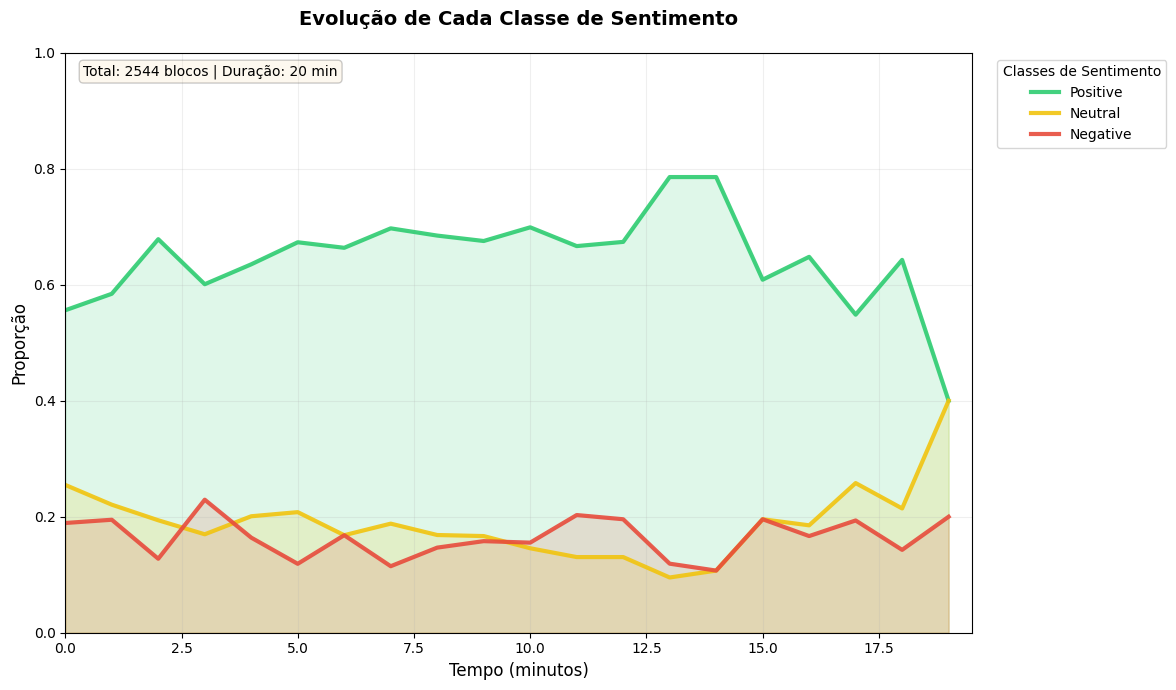


✅ Gráfico salvo: grafico4_linhas_classes.png


In [27]:
# @title
# =============================================================
# CÉLULA 7: GRÁFICO 4 - LINHAS SEPARADAS POR CLASSE
# =============================================================
print("\n📈 GERANDO GRÁFICO 4: Linhas por Classe")

if not df_combined.empty:
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 7))

    # Preparar dados
    df_combined['time_min'] = df_combined['start_seconds'] / 60
    max_time_min = df_combined['time_min'].max()

    # Agrupar
    bin_size_min = max(1, round(max_time_min / 25))
    df_combined['time_bin'] = (df_combined['time_min'] // bin_size_min) * bin_size_min

    # Calcular proporções garantindo todas as classes
    sentiment_classes = df_combined['sentiment'].unique()
    grouped = df_combined.groupby(['time_bin', 'sentiment']).size().unstack(fill_value=0)

    # Garantir todas as classes
    for sentiment in sentiment_classes:
        if sentiment not in grouped.columns:
            grouped[sentiment] = 0

    # Normalizar por linha
    grouped_norm = grouped.div(grouped.sum(axis=1), axis=0)

    # Cores específicas + extras
    color_map = {
        'Positive': '#2ecc71',
        'Neutral': '#f1c40f',
        'Negative': '#e74c3c'
    }

    # Plotar cada classe como linha separada
    for i, sentiment in enumerate(sentiment_classes):
        color = color_map.get(sentiment, f'C{i}')

        # Plot linha principal
        ax.plot(grouped_norm.index, grouped_norm[sentiment],
                color=color,
                linewidth=3,
                marker='o' if len(grouped_norm) < 20 else '',
                markersize=6,
                label=f'{sentiment}',
                alpha=0.9)

        # Área sombreada abaixo da linha
        ax.fill_between(grouped_norm.index, grouped_norm[sentiment], 0,
                        color=color, alpha=0.15)

    # Configurações
    ax.set_xlabel('Tempo (minutos)', fontsize=12)
    ax.set_ylabel('Proporção', fontsize=12)
    ax.set_title('Evolução de Cada Classe de Sentimento',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, max_time_min)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.2)

    # Legenda com todas as classes
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1),
              title="Classes de Sentimento", frameon=True)

    # Anotar estatísticas
    stats_text = f"Total: {len(df_combined)} blocos | Duração: {max_time_min:.0f} min"
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig('grafico4_linhas_classes.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Gráfico salvo: grafico4_linhas_classes.png")


🎨 GERANDO GRÁFICO 5: Métricas por Sentimento


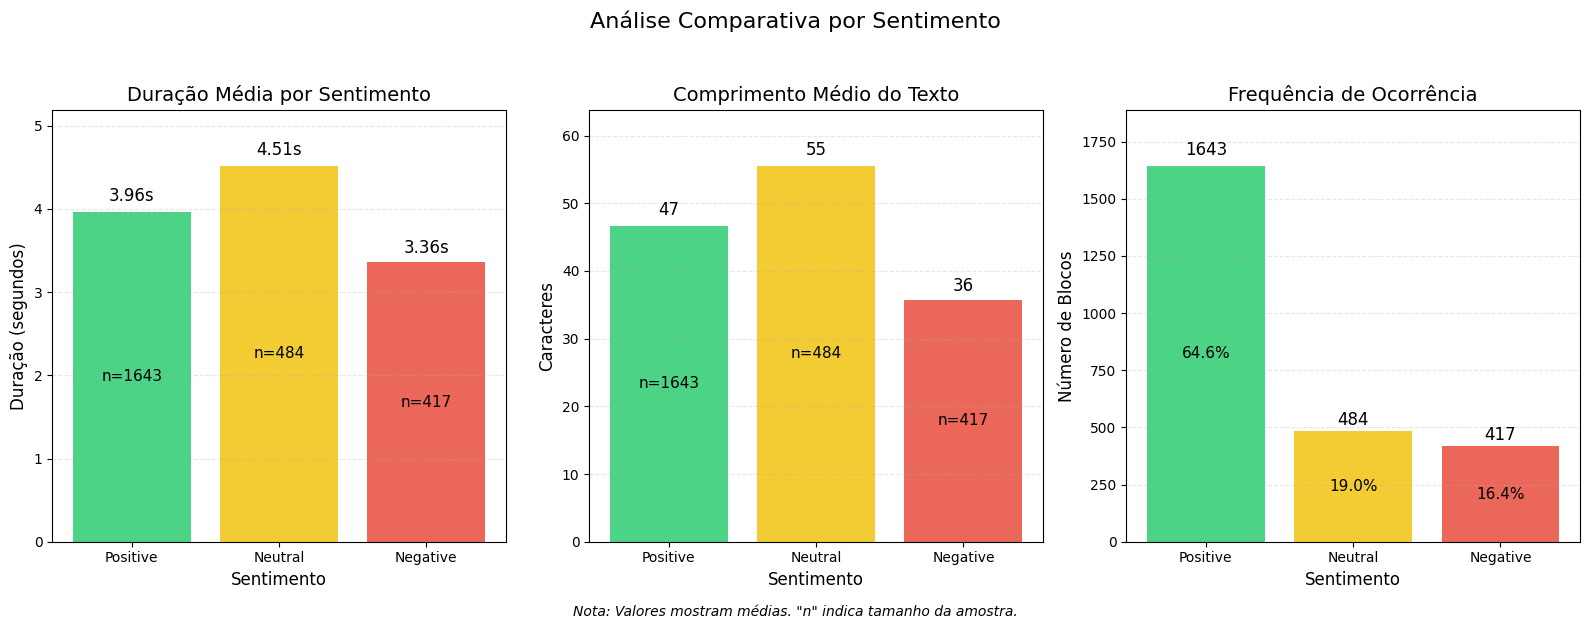


📊 RESULTADOS DETALHADOS POR SENTIMENTO:

   Positive:
     📏 Duração: 3.36s (σ=2.88, n=1643)
     📝 Comprimento: 36 chars (σ=32, n=1643)
     📊 Frequência: 1643 blocos (64.6%)

   Neutral:
     📏 Duração: 4.51s (σ=3.72, n=484)
     📝 Comprimento: 55 chars (σ=45, n=484)
     📊 Frequência: 484 blocos (19.0%)

   Negative:
     📏 Duração: 3.96s (σ=2.98, n=417)
     📝 Comprimento: 47 chars (σ=34, n=417)
     📊 Frequência: 417 blocos (16.4%)

📈 CORRELAÇÕES:
   Duração vs Sentimento: r = -0.108
      📊 Correlação FRACA NEGATIVA (📉)
      💡 Interpretação: blocos mais longos tendem a ser mais negativos

   Comprimento vs Sentimento: r = -0.162
      📊 Correlação FRACA NEGATIVA (📉)
      💡 Interpretação: textos mais longos tendem a ser mais negativos

🔬 ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA:
   📏 DIFERENÇAS NA DURAÇÃO:
      F(2, 2541) = 28.73
      p-value = 0.0000
      ✅ DIFERENÇAS SIGNIFICATIVAS (p < 0.05)
      🔍 Comparações pareadas:
        • Positive vs Neutral: p = 0.000 (diferença = 1

In [28]:
# @title
# =============================================================
# CÉLULA 8: GRÁFICO 5 - MÉTRICAS POR SENTIMENTO (SEM DESVIO PADRÃO)
# =============================================================
print("\n🎨 GERANDO GRÁFICO 5: Métricas por Sentimento")

if not df_combined.empty:
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))

    colors = ['#2ecc71', '#f1c40f', '#e74c3c']
    sentiments = ['Positive', 'Neutral', 'Negative']

    # 1. Duração média
    duration_stats = df_combined.groupby('sentiment')['duration'].agg(['mean', 'count'])

    # Calcular posições para os textos
    max_duration = duration_stats['mean'].max()
    text_height_duration = max_duration * 1.15  # 15% acima do máximo

    bars1 = axes[0].bar(sentiments,
                       duration_stats['mean'],
                       color=colors,
                       edgecolor='black',
                       linewidth=0,
                       alpha=0.85)

    # TÍTULOS E RÓTULOS EM PRETO, SEM NEGRITO
    axes[0].set_title('Duração Média por Sentimento', fontsize=14, fontweight='normal', color='black')
    axes[0].set_xlabel('Sentimento', fontsize=12, fontweight='normal', color='black')
    axes[0].set_ylabel('Duração (segundos)', fontsize=12, fontweight='normal', color='black')
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')

    # Configurar cor dos ticks
    axes[0].tick_params(axis='both', colors='black')

    # Adicionar valores nas barras (PRETO, SEM NEGRITO)
    for i, (sentiment, mean_val) in enumerate(zip(sentiments, duration_stats['mean'])):
        # Valor principal no topo da barra
        height = mean_val
        axes[0].text(i, height * 1.02,  # 2% acima da barra
                    f'{mean_val:.2f}s',
                    ha='center', va='bottom',
                    fontsize=12, fontweight='normal',  # SEM NEGRITO
                    color='black')  # PRETO

        # Tamanho da amostra no meio da barra - TAMBÉM EM PRETO
        n_count = duration_stats.loc[sentiment, 'count']
        mid_height = height / 2

        axes[0].text(i, mid_height,
                    f'n={n_count}',
                    ha='center', va='center',
                    fontsize=11, fontweight='normal',  # SEM NEGRITO
                    color='black')  # PRETO (não mais branco)

    # Ajustar limite Y
    axes[0].set_ylim([0, text_height_duration])

    # 2. Comprimento do texto
    length_stats = df_combined.groupby('sentiment')['text_length'].agg(['mean', 'count'])

    # Calcular posições para os textos
    max_length = length_stats['mean'].max()
    text_height_length = max_length * 1.15

    bars2 = axes[1].bar(sentiments,
                       length_stats['mean'],
                       color=colors,
                       edgecolor='black',
                       linewidth=0,
                       alpha=0.85)

    # TÍTULOS E RÓTULOS EM PRETO, SEM NEGRITO
    axes[1].set_title('Comprimento Médio do Texto', fontsize=14, fontweight='normal', color='black')
    axes[1].set_xlabel('Sentimento', fontsize=12, fontweight='normal', color='black')
    axes[1].set_ylabel('Caracteres', fontsize=12, fontweight='normal', color='black')
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')

    # Configurar cor dos ticks
    axes[1].tick_params(axis='both', colors='black')

    # Adicionar valores nas barras (PRETO, SEM NEGRITO)
    for i, (sentiment, mean_val) in enumerate(zip(sentiments, length_stats['mean'])):
        # Valor principal no topo da barra
        height = mean_val
        axes[1].text(i, height * 1.02,  # 2% acima da barra
                    f'{mean_val:.0f}',
                    ha='center', va='bottom',
                    fontsize=12, fontweight='normal',  # SEM NEGRITO
                    color='black')  # PRETO

        # Tamanho da amostra no meio da barra - TAMBÉM EM PRETO
        n_count = length_stats.loc[sentiment, 'count']
        mid_height = height / 2

        axes[1].text(i, mid_height,
                    f'n={n_count}',
                    ha='center', va='center',
                    fontsize=11, fontweight='normal',  # SEM NEGRITO
                    color='black')  # PRETO (não mais branco)

    # Ajustar limite Y
    axes[1].set_ylim([0, text_height_length])

    # 3. Frequência de ocorrência
    freq_stats = df_combined['sentiment'].value_counts()

    # Calcular posições para os textos
    max_freq = freq_stats.max()
    text_height_freq = max_freq * 1.15

    bars3 = axes[2].bar(sentiments,
                       freq_stats.values,
                       color=colors,
                       edgecolor='black',
                       linewidth=0,
                       alpha=0.85)

    # TÍTULOS E RÓTULOS EM PRETO, SEM NEGRITO
    axes[2].set_title('Frequência de Ocorrência', fontsize=14, fontweight='normal', color='black')
    axes[2].set_xlabel('Sentimento', fontsize=12, fontweight='normal', color='black')
    axes[2].set_ylabel('Número de Blocos', fontsize=12, fontweight='normal', color='black')
    axes[2].grid(axis='y', alpha=0.3, linestyle='--')

    # Configurar cor dos ticks
    axes[2].tick_params(axis='both', colors='black')

    # Adicionar valores nas barras (PRETO, SEM NEGRITO)
    for i, (sentiment, count) in enumerate(zip(sentiments, freq_stats.values)):
        # Valor principal no topo da barra
        height = count
        axes[2].text(i, height * 1.02,  # 2% acima da barra
                    f'{count}',
                    ha='center', va='bottom',
                    fontsize=12, fontweight='normal',  # SEM NEGRITO
                    color='black')  # PRETO

        # Porcentagem no meio da barra - TAMBÉM EM PRETO
        percentage = (count / len(df_combined)) * 100
        mid_height = height / 2

        axes[2].text(i, mid_height,
                    f'{percentage:.1f}%',
                    ha='center', va='center',
                    fontsize=11, fontweight='normal',  # SEM NEGRITO
                    color='black')  # PRETO (não mais branco)

    # Ajustar limite Y
    axes[2].set_ylim([0, text_height_freq])

    # Adicionar título geral (PRETO, SEM NEGRITO)
    plt.suptitle('Análise Comparativa por Sentimento',
                fontsize=16, fontweight='normal', color='black', y=1.02)

    # Adicionar legenda explicativa (PRETO, SEM NEGRITO)
    fig.text(0.5, 0.01,
             'Nota: Valores mostram médias. "n" indica tamanho da amostra.',
             ha='center', fontsize=10, fontweight='normal', style='italic', color='black')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig('grafico5_metricas_por_sentimento.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Resultados numéricos detalhados (incluindo desvio padrão no console)
    print("\n📊 RESULTADOS DETALHADOS POR SENTIMENTO:")

    # Recalcular estatísticas completas para exibição no console
    full_stats = df_combined.groupby('sentiment').agg({
        'duration': ['mean', 'std', 'count'],
        'text_length': ['mean', 'std', 'count']
    })

    for i, sentiment in enumerate(sentiments):
        print(f"\n   {sentiment}:")

        # Duração
        duration_mean = full_stats.loc[sentiment, ('duration', 'mean')]
        duration_std = full_stats.loc[sentiment, ('duration', 'std')]
        duration_n = full_stats.loc[sentiment, ('duration', 'count')]

        print(f"     📏 Duração: {duration_mean:.2f}s (σ={duration_std:.2f}, n={duration_n})")

        # Comprimento
        length_mean = full_stats.loc[sentiment, ('text_length', 'mean')]
        length_std = full_stats.loc[sentiment, ('text_length', 'std')]
        length_n = full_stats.loc[sentiment, ('text_length', 'count')]

        print(f"     📝 Comprimento: {length_mean:.0f} chars (σ={length_std:.0f}, n={length_n})")

        # Frequência
        freq = freq_stats[sentiment]
        percentage = freq / len(df_combined) * 100
        print(f"     📊 Frequência: {freq} blocos ({percentage:.1f}%)")

    # Análise de correlação
    print("\n📈 CORRELAÇÕES:")

    # Correlação entre duração e sentimento
    duration_corr = df_combined[['duration', 'sentiment_numeric']].corr().iloc[0, 1]
    print(f"   Duração vs Sentimento: r = {duration_corr:.3f}")

    if abs(duration_corr) > 0.5:
        strength = "FORTE"
        strength_emoji = "🔥"
    elif abs(duration_corr) > 0.3:
        strength = "MODERADA"
        strength_emoji = "📈"
    elif abs(duration_corr) > 0.1:
        strength = "FRACA"
        strength_emoji = "📊"
    else:
        strength = "MUITO FRACA"
        strength_emoji = "📉"

    if duration_corr > 0:
        direction = "POSITIVA"
        direction_emoji = "📈"
        interpretation = "blocos mais longos tendem a ser mais positivos"
    else:
        direction = "NEGATIVA"
        direction_emoji = "📉"
        interpretation = "blocos mais longos tendem a ser mais negativos"

    print(f"      {strength_emoji} Correlação {strength} {direction} ({direction_emoji})")
    print(f"      💡 Interpretação: {interpretation}")

    # Correlação entre comprimento e sentimento
    length_corr = df_combined[['text_length', 'sentiment_numeric']].corr().iloc[0, 1]
    print(f"\n   Comprimento vs Sentimento: r = {length_corr:.3f}")

    if abs(length_corr) > 0.5:
        strength = "FORTE"
        strength_emoji = "🔥"
    elif abs(length_corr) > 0.3:
        strength = "MODERADA"
        strength_emoji = "📈"
    elif abs(length_corr) > 0.1:
        strength = "FRACA"
        strength_emoji = "📊"
    else:
        strength = "MUITO FRACA"
        strength_emoji = "📉"

    if length_corr > 0:
        direction = "POSITIVA"
        direction_emoji = "📈"
        interpretation = "textos mais longos tendem a ser mais positivos"
    else:
        direction = "NEGATIVA"
        direction_emoji = "📉"
        interpretation = "textos mais longos tendem a ser mais negativos"

    print(f"      {strength_emoji} Correlação {strength} {direction} ({direction_emoji})")
    print(f"      💡 Interpretação: {interpretation}")

    # Análise de significância estatística
    print("\n🔬 ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA:")

    from scipy import stats

    # Teste ANOVA para duração
    groups_duration = [df_combined[df_combined['sentiment'] == s]['duration'] for s in sentiments]
    f_stat_duration, p_val_duration = stats.f_oneway(*groups_duration)

    print(f"   📏 DIFERENÇAS NA DURAÇÃO:")
    print(f"      F({len(groups_duration)-1}, {len(df_combined)-len(groups_duration)}) = {f_stat_duration:.2f}")
    print(f"      p-value = {p_val_duration:.4f}")

    if p_val_duration < 0.05:
        print(f"      ✅ DIFERENÇAS SIGNIFICATIVAS (p < 0.05)")

        # Comparações pareadas
        print(f"      🔍 Comparações pareadas:")
        for i in range(len(sentiments)):
            for j in range(i+1, len(sentiments)):
                t_stat, p_val = stats.ttest_ind(groups_duration[i], groups_duration[j])
                if p_val < 0.05:
                    mean_i = groups_duration[i].mean()
                    mean_j = groups_duration[j].mean()
                    diff = abs(mean_i - mean_j)
                    print(f"        • {sentiments[i]} vs {sentiments[j]}: p = {p_val:.3f} (diferença = {diff:.2f}s)")
    else:
        print(f"      ⚠️  SEM DIFERENÇAS SIGNIFICATIVAS (p ≥ 0.05)")

    # Teste ANOVA para comprimento
    groups_length = [df_combined[df_combined['sentiment'] == s]['text_length'] for s in sentiments]
    f_stat_length, p_val_length = stats.f_oneway(*groups_length)

    print(f"\n   📝 DIFERENÇAS NO COMPRIMENTO:")
    print(f"      F({len(groups_length)-1}, {len(df_combined)-len(groups_length)}) = {f_stat_length:.2f}")
    print(f"      p-value = {p_val_length:.4f}")

    if p_val_length < 0.05:
        print(f"      ✅ DIFERENÇAS SIGNIFICATIVAS (p < 0.05)")
    else:
        print(f"      ⚠️  SEM DIFERENÇAS SIGNIFICATIVAS (p ≥ 0.05)")

    print(f"\n✅ Gráfico 5 salvo: grafico5_metricas_por_sentimento.png")

    # Estatísticas de resumo
    print(f"\n🎯 ESTATÍSTICAS DE RESUMO:")

    # Duração
    duration_max_sentiment = duration_stats['mean'].idxmax()
    duration_max_value = duration_stats['mean'].max()
    duration_min_sentiment = duration_stats['mean'].idxmin()
    duration_min_value = duration_stats['mean'].min()
    duration_range = duration_max_value - duration_min_value

    print(f"   📏 DURAÇÃO:")
    print(f"      • Mais longo: {duration_max_sentiment} ({duration_max_value:.2f}s)")
    print(f"      • Mais curto: {duration_min_sentiment} ({duration_min_value:.2f}s)")
    print(f"      • Variação: {duration_range:.2f}s ({duration_max_value/duration_min_value:.1f}x)")

    # Comprimento
    length_max_sentiment = length_stats['mean'].idxmax()
    length_max_value = length_stats['mean'].max()
    length_min_sentiment = length_stats['mean'].idxmin()
    length_min_value = length_stats['mean'].min()
    length_range = length_max_value - length_min_value

    print(f"\n   📝 COMPRIMENTO:")
    print(f"      • Mais longo: {length_max_sentiment} ({length_max_value:.0f} chars)")
    print(f"      • Mais curto: {length_min_sentiment} ({length_min_value:.0f} chars)")
    print(f"      • Variação: {length_range:.0f} chars ({length_max_value/length_min_value:.1f}x)")

    # Frequência
    freq_max_sentiment = freq_stats.idxmax()
    freq_max_value = freq_stats.max()
    freq_min_sentiment = freq_stats.idxmin()
    freq_min_value = freq_stats.min()
    freq_range = freq_max_value - freq_min_value

    print(f"\n   📊 FREQUÊNCIA:")
    print(f"      • Mais frequente: {freq_max_sentiment} ({freq_max_value} blocos, {freq_max_value/len(df_combined)*100:.1f}%)")
    print(f"      • Menos frequente: {freq_min_sentiment} ({freq_min_value} blocos, {freq_min_value/len(df_combined)*100:.1f}%)")
    print(f"      • Variação: {freq_range} blocos ({freq_max_value/freq_min_value:.1f}x)")

    # Análise de balanceamento
    print(f"\n⚖️  ANÁLISE DE BALANCEAMENTO:")
    max_percentage = freq_max_value / len(df_combined) * 100
    min_percentage = freq_min_value / len(df_combined) * 100
    imbalance_ratio = max_percentage / min_percentage

    if imbalance_ratio > 3:
        balance_status = "MUITO DESBALANCEADO"
        balance_emoji = "⚠️"
    elif imbalance_ratio > 2:
        balance_status = "DESBALANCEADO"
        balance_emoji = "⚖️"
    elif imbalance_ratio > 1.5:
        balance_status = "MODERADAMENTE BALANCEADO"
        balance_emoji = "📊"
    else:
        balance_status = "BEM BALANCEADO"
        balance_emoji = "✅"

    print(f"   {balance_emoji} {balance_status}")
    print(f"   Razão maior/menor: {imbalance_ratio:.1f}x")

else:
    print("❌ Nenhum dado para gerar gráfico")


🎨 GERANDO GRÁFICO 6: Gráfico de Pizza

📊 ESTATÍSTICAS PARA GRÁFICO DE PIZZA:
   Positive: 1643 blocos (64.6%)
   Neutral: 484 blocos (19.0%)
   Negative: 417 blocos (16.4%)


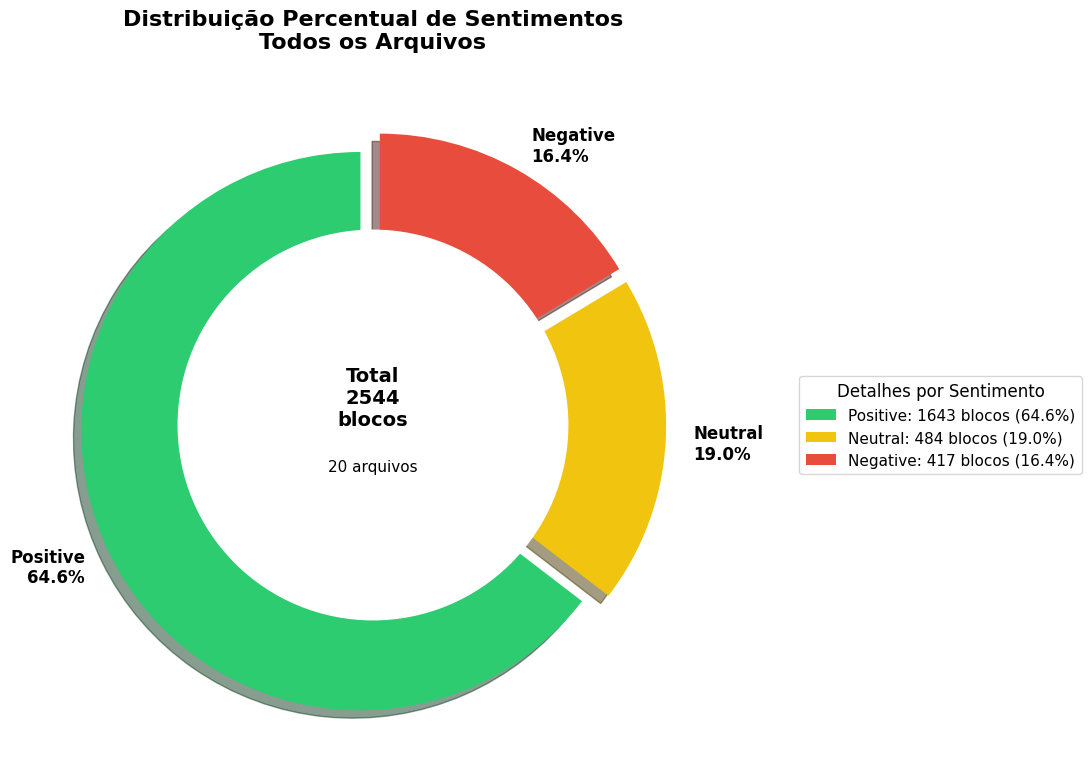


📈 ANÁLISE DE DOMINÂNCIA:
   🥇 Positive é DOMINANTE (64.6% dos blocos)
   📐 Índice de Diversidade: 0.520
     ⚖️  Diversidade moderada

✅ Gráfico 6 salvo: grafico6_distribuicao_percentual.png
   Sentimento predominante: Positive (64.6%)
   Balanceamento: 0.520 (1.0 = máxima diversidade)


In [29]:
# @title
# =============================================================
# CÉLULA 9: GRÁFICO 6 - GRÁFICO DE PIZZA
# =============================================================
print("\n🎨 GERANDO GRÁFICO 6: Gráfico de Pizza")

if not df_combined.empty:
    plt.figure(figsize=(10, 8))

    sentiment_counts = df_combined['sentiment'].value_counts()
    colors = ['#2ecc71', '#f1c40f', '#e74c3c']

    # Calcular estatísticas para o gráfico
    total = len(df_combined)
    percentages = (sentiment_counts / total * 100).round(1)

    print("\n📊 ESTATÍSTICAS PARA GRÁFICO DE PIZZA:")
    for sentiment, count in sentiment_counts.items():
        pct = percentages[sentiment]
        print(f"   {sentiment}: {count} blocos ({pct}%)")

    # Criar labels com porcentagem
    labels = [f'{sentiment}\n{percentages[sentiment]}%'
              for sentiment in sentiment_counts.index]

    # Criar gráfico de pizza
    wedges, texts, autotexts = plt.pie(sentiment_counts.values,
                                       labels=labels,
                                       colors=colors,
                                       autopct='',
                                       startangle=90,
                                       explode=[0.05, 0.05, 0.05],
                                       shadow=True,
                                       textprops={'fontsize': 12})

    # Melhorar aparência
    plt.setp(texts, size=12, weight="bold")

    plt.title('Distribuição Percentual de Sentimentos\nTodos os Arquivos',
              fontsize=16, fontweight='bold', pad=20)

    # Adicionar legenda detalhada
    legend_labels = []
    for sentiment, count in sentiment_counts.items():
        pct = percentages[sentiment]
        legend_labels.append(f'{sentiment}: {count} blocos ({pct}%)')

    plt.legend(wedges, legend_labels,
               title="Detalhes por Sentimento",
               loc="center left",
               bbox_to_anchor=(1.1, 0, 0.5, 1),
               fontsize=11,
               title_fontsize=12)

    # Adicionar estatísticas no centro
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.text(0, 0.1, f"Total\n{total}\nblocos",
             ha='center', va='center',
             fontsize=14, fontweight='bold')

    plt.text(0, -0.15, f"{df_combined['file_name'].nunique()} arquivos",
             ha='center', va='center',
             fontsize=11)

    plt.tight_layout()
    plt.savefig('grafico6_distribuicao_percentual.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Análise de dominância
    print("\n📈 ANÁLISE DE DOMINÂNCIA:")
    dominant_sentiment = sentiment_counts.index[0]
    dominant_percentage = percentages[dominant_sentiment]

    if dominant_percentage > 50:
        print(f"   🥇 {dominant_sentiment} é DOMINANTE ({dominant_percentage}% dos blocos)")
    elif dominant_percentage > 40:
        print(f"   🥈 {dominant_sentiment} é MAJORITÁRIO ({dominant_percentage}% dos blocos)")
    elif dominant_percentage > 30:
        print(f"   🥉 {dominant_sentiment} é FREQUENTE ({dominant_percentage}% dos blocos)")
    else:
        print(f"   📊 Distribuição BALANCEADA (maior: {dominant_sentiment} com {dominant_percentage}%)")

    # Calcular índice de diversidade
    diversity_index = 1 - sum((sentiment_counts / total) ** 2)
    print(f"   📐 Índice de Diversidade: {diversity_index:.3f}")
    if diversity_index > 0.6:
        print("     🎭 Alta diversidade de sentimentos")
    elif diversity_index > 0.4:
        print("     ⚖️  Diversidade moderada")
    else:
        print("     🎯 Baixa diversidade (foco em um sentimento)")

    print(f"\n✅ Gráfico 6 salvo: grafico6_distribuicao_percentual.png")
    print(f"   Sentimento predominante: {dominant_sentiment} ({dominant_percentage}%)")
    print(f"   Balanceamento: {diversity_index:.3f} (1.0 = máxima diversidade)")
else:
    print("❌ Nenhum dado para gerar gráfico")


📊 GERANDO GRÁFICO 7: Box Plot Comparativo

🎯 CLASSES DETECTADAS: ['Positive', 'Neutral', 'Negative']


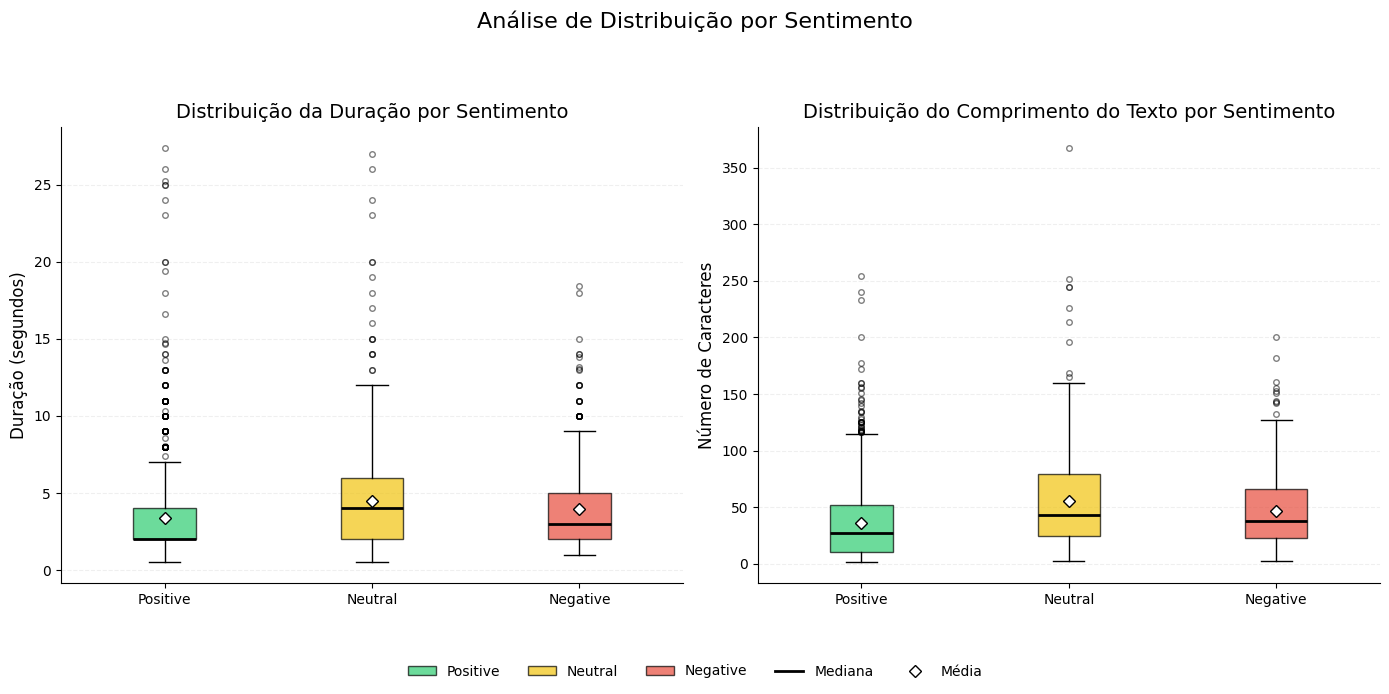


📊 ESTATÍSTICAS DETALHADAS:

   Positive (#2ecc71):
     📏 DURAÇÃO:
       • Média: 3.36s
       • Mediana: 2.00s
       • Q1: 2.00s
       • Q3: 4.00s
       • IQR: 2.00s
       • Desvio padrão: 2.88s
       • Min-Max: [0.50s, 27.40s]

     📝 COMPRIMENTO:
       • Média: 36 chars
       • Mediana: 27 chars
       • Q1: 10 chars
       • Q3: 52 chars
       • IQR: 42 chars
       • Desvio padrão: 32 chars
       • Min-Max: [1, 254]

   Neutral (#f1c40f):
     📏 DURAÇÃO:
       • Média: 4.51s
       • Mediana: 4.00s
       • Q1: 2.00s
       • Q3: 6.00s
       • IQR: 4.00s
       • Desvio padrão: 3.72s
       • Min-Max: [0.50s, 27.00s]

     📝 COMPRIMENTO:
       • Média: 55 chars
       • Mediana: 43 chars
       • Q1: 24 chars
       • Q3: 79 chars
       • IQR: 55 chars
       • Desvio padrão: 45 chars
       • Min-Max: [2, 368]

   Negative (#e74c3c):
     📏 DURAÇÃO:
       • Média: 3.96s
       • Mediana: 3.00s
       • Q1: 2.00s
       • Q3: 5.00s
       • IQR: 3.00s
       • Desv

In [30]:
# @title
# =============================================================
# CÉLULA 10: GRÁFICO 7 - BOX PLOT COMPARATIVO (MELHORADO)
# =============================================================
print("\n📊 GERANDO GRÁFICO 7: Box Plot Comparativo")

if not df_combined.empty:
    # Configuração clean
    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Identificar automaticamente todas as classes de sentimento
    sentiment_classes = df_combined['sentiment'].unique()
    print(f"\n🎯 CLASSES DETECTADAS: {list(sentiment_classes)}")

    # Mapeamento de cores (suas cores específicas + extras se necessário)
    color_map = {
        'Positive': '#2ecc71',
        'Neutral': '#f1c40f',
        'Negative': '#e74c3c'
    }

    # Adicionar cores para outras classes se existirem
    additional_colors = ['#9b59b6', '#3498db', '#1abc9c', '#e67e22']
    for i, sentiment in enumerate(sentiment_classes):
        if sentiment not in color_map:
            color_map[sentiment] = additional_colors[i % len(additional_colors)]

    # 1. BOX PLOT DA DURAÇÃO
    duration_data = [df_combined[df_combined['sentiment'] == s]['duration']
                    for s in sentiment_classes]

    colors_list = [color_map[s] for s in sentiment_classes]

    bp1 = axes[0].boxplot(duration_data,
                         labels=sentiment_classes,
                         patch_artist=True,
                         medianprops={'color': 'black', 'linewidth': 2},
                         showmeans=True,
                         meanprops={'marker': 'D', 'markerfacecolor': 'white',
                                   'markeredgecolor': 'black', 'markersize': 6},
                         flierprops={'marker': 'o', 'markersize': 4, 'alpha': 0.5})

    # Colorir as caixas
    for patch, color in zip(bp1['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1)

    # Configuração do primeiro gráfico
    axes[0].set_title('Distribuição da Duração por Sentimento',
                     fontsize=14, fontweight='normal', color='black')
    axes[0].set_ylabel('Duração (segundos)', fontsize=12, fontweight='normal', color='black')
    axes[0].tick_params(axis='both', colors='black')
    axes[0].grid(True, alpha=0.2, linestyle='--', axis='y')

    # Remover bordas desnecessárias
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # 2. BOX PLOT DO COMPRIMENTO DO TEXTO
    length_data = [df_combined[df_combined['sentiment'] == s]['text_length']
                  for s in sentiment_classes]

    bp2 = axes[1].boxplot(length_data,
                         labels=sentiment_classes,
                         patch_artist=True,
                         medianprops={'color': 'black', 'linewidth': 2},
                         showmeans=True,
                         meanprops={'marker': 'D', 'markerfacecolor': 'white',
                                   'markeredgecolor': 'black', 'markersize': 6},
                         flierprops={'marker': 'o', 'markersize': 4, 'alpha': 0.5})

    # Colorir as caixas
    for patch, color in zip(bp2['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1)

    # Configuração do segundo gráfico
    axes[1].set_title('Distribuição do Comprimento do Texto por Sentimento',
                     fontsize=14, fontweight='normal', color='black')
    axes[1].set_ylabel('Número de Caracteres', fontsize=12, fontweight='normal', color='black')
    axes[1].tick_params(axis='both', colors='black')
    axes[1].grid(True, alpha=0.2, linestyle='--', axis='y')

    # Remover bordas desnecessárias
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # Título geral
    plt.suptitle('Análise de Distribuição por Sentimento',
                fontsize=16, fontweight='normal', color='black', y=1.02)

    # Legenda explicativa
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor=color_map[sentiment], alpha=0.7, edgecolor='black',
              label=f'{sentiment}') for sentiment in sentiment_classes
    ]

    # Adicionar elementos da legenda para mediana e média
    legend_elements.extend([
        plt.Line2D([0], [0], color='black', linewidth=2, label='Mediana'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='white',
                  markeredgecolor='black', markersize=6, label='Média')
    ])

    fig.legend(handles=legend_elements,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=min(len(sentiment_classes) + 2, 5),
               fontsize=10,
               frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('grafico7_boxplot_comparativo.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # ==========================
    # ANÁLISE ESTATÍSTICA DETALHADA
    # ==========================
    print("\n📊 ESTATÍSTICAS DETALHADAS:")

    for i, sentiment in enumerate(sentiment_classes):
        duration_values = df_combined[df_combined['sentiment'] == sentiment]['duration']
        length_values = df_combined[df_combined['sentiment'] == sentiment]['text_length']

        print(f"\n   {sentiment} ({color_map[sentiment]}):")
        print(f"     📏 DURAÇÃO:")
        print(f"       • Média: {duration_values.mean():.2f}s")
        print(f"       • Mediana: {duration_values.median():.2f}s")
        print(f"       • Q1: {duration_values.quantile(0.25):.2f}s")
        print(f"       • Q3: {duration_values.quantile(0.75):.2f}s")
        print(f"       • IQR: {duration_values.quantile(0.75) - duration_values.quantile(0.25):.2f}s")
        print(f"       • Desvio padrão: {duration_values.std():.2f}s")
        print(f"       • Min-Max: [{duration_values.min():.2f}s, {duration_values.max():.2f}s]")

        print(f"\n     📝 COMPRIMENTO:")
        print(f"       • Média: {length_values.mean():.0f} chars")
        print(f"       • Mediana: {length_values.median():.0f} chars")
        print(f"       • Q1: {length_values.quantile(0.25):.0f} chars")
        print(f"       • Q3: {length_values.quantile(0.75):.0f} chars")
        print(f"       • IQR: {length_values.quantile(0.75) - length_values.quantile(0.25):.0f} chars")
        print(f"       • Desvio padrão: {length_values.std():.0f} chars")
        print(f"       • Min-Max: [{length_values.min():.0f}, {length_values.max():.0f}]")

    # ==========================
    # TESTES ESTATÍSTICOS
    # ==========================
    from scipy import stats
    from itertools import combinations

    print(f"\n📈 TESTES DE DIFERENÇAS ENTRE GRUPOS:")

    # Teste ANOVA para duração
    duration_groups = [df_combined[df_combined['sentiment'] == s]['duration']
                      for s in sentiment_classes]
    f_stat_duration, p_val_duration = stats.f_oneway(*duration_groups)

    print(f"\n   📏 DURAÇÃO - Teste ANOVA:")
    print(f"     F({len(duration_groups)-1}, {len(df_combined)-len(duration_groups)}) = {f_stat_duration:.3f}")
    print(f"     p-value = {p_val_duration:.4f}")

    if p_val_duration < 0.05:
        print("     ✅ Diferenças SIGNIFICATIVAS (p < 0.05)")

        # Testes post-hoc (Tukey ou Mann-Whitney)
        print(f"     🔍 Testes pareados (Mann-Whitney):")
        for s1, s2 in combinations(sentiment_classes, 2):
            group1 = df_combined[df_combined['sentiment'] == s1]['duration']
            group2 = df_combined[df_combined['sentiment'] == s2]['duration']

            u_stat, p_val = stats.mannwhitneyu(group1, group2)
            mean_diff = group1.mean() - group2.mean()

            if p_val < 0.05:
                significance = "✅ SIGNIFICATIVO"
            elif p_val < 0.1:
                significance = "⚠️  MARGINAL"
            else:
                significance = "❌ NÃO SIGNIFICATIVO"

            print(f"       • {s1} vs {s2}: p = {p_val:.4f} (diferença = {mean_diff:.2f}s) {significance}")
    else:
        print("     ⚠️  Diferenças NÃO significativas (p ≥ 0.05)")

    # Teste ANOVA para comprimento
    length_groups = [df_combined[df_combined['sentiment'] == s]['text_length']
                    for s in sentiment_classes]
    f_stat_length, p_val_length = stats.f_oneway(*length_groups)

    print(f"\n   📝 COMPRIMENTO - Teste ANOVA:")
    print(f"     F({len(length_groups)-1}, {len(df_combined)-len(length_groups)}) = {f_stat_length:.3f}")
    print(f"     p-value = {p_val_length:.4f}")

    if p_val_length < 0.05:
        print("     ✅ Diferenças SIGNIFICATIVAS (p < 0.05)")
    else:
        print("     ⚠️  Diferenças NÃO significativas (p ≥ 0.05)")

    # ==========================
    # ANÁLISE DE OUTLIERS
    # ==========================
    print(f"\n🎯 ANÁLISE DE OUTLIERS:")

    for sentiment in sentiment_classes:
        duration_values = df_combined[df_combined['sentiment'] == sentiment]['duration']
        length_values = df_combined[df_combined['sentiment'] == sentiment]['text_length']

        # Identificar outliers (valores fora de Q1 - 1.5*IQR ou Q3 + 1.5*IQR)
        Q1_duration = duration_values.quantile(0.25)
        Q3_duration = duration_values.quantile(0.75)
        IQR_duration = Q3_duration - Q1_duration
        outliers_duration = duration_values[(duration_values < (Q1_duration - 1.5 * IQR_duration)) |
                                          (duration_values > (Q3_duration + 1.5 * IQR_duration))]

        Q1_length = length_values.quantile(0.25)
        Q3_length = length_values.quantile(0.75)
        IQR_length = Q3_length - Q1_length
        outliers_length = length_values[(length_values < (Q1_length - 1.5 * IQR_length)) |
                                       (length_values > (Q3_length + 1.5 * IQR_length))]

        print(f"\n   {sentiment}:")
        print(f"     📏 Duração: {len(outliers_duration)} outliers "
              f"({len(outliers_duration)/len(duration_values)*100:.1f}%)")
        if len(outliers_duration) > 0:
            print(f"       • Valores: {sorted(outliers_duration.values)[:5]}..."
                  if len(outliers_duration) > 5 else f"       • Valores: {sorted(outliers_duration.values)}")

        print(f"     📝 Comprimento: {len(outliers_length)} outliers "
              f"({len(outliers_length)/len(length_values)*100:.1f}%)")
        if len(outliers_length) > 0:
            print(f"       • Valores: {sorted(outliers_length.values)[:5]}..."
                  if len(outliers_length) > 5 else f"       • Valores: {sorted(outliers_length.values)}")

    # ==========================
    # RESUMO FINAL
    # ==========================
    print(f"\n🎯 RESUMO FINAL:")

    # Duração mais variável
    duration_variability = {s: df_combined[df_combined['sentiment'] == s]['duration'].std()
                          for s in sentiment_classes}
    most_variable_duration = max(duration_variability, key=duration_variability.get)

    # Comprimento mais variável
    length_variability = {s: df_combined[df_combined['sentiment'] == s]['text_length'].std()
                         for s in sentiment_classes}
    most_variable_length = max(length_variability, key=length_variability.get)

    print(f"   📏 Duração mais variável: {most_variable_duration} "
          f"(σ={duration_variability[most_variable_duration]:.2f}s)")
    print(f"   📝 Comprimento mais variável: {most_variable_length} "
          f"(σ={length_variability[most_variable_length]:.0f} chars)")

    print(f"\n✅ Gráfico 7 salvo: grafico7_boxplot_comparativo.png")
    print(f"   Classes analisadas: {', '.join(sentiment_classes)}")
    print(f"   Total de observações: {len(df_combined)} blocos")
    print(f"   Significância estatística: p < 0.05")

else:
    print("❌ Nenhum dado para gerar gráfico")


🎨 GERANDO GRÁFICO 8: Análise de Componentes Principais (PCA)

📊 RESULTADOS DO PCA:
   Variância explicada PC1: 61.9%
   Variância explicada PC2: 32.0%
   Variância total explicada: 93.9%

📈 LOADINGS (Contribuições das Variáveis):
               PC1    PC2
Duração      0.687  0.188
Comprimento  0.694  0.119
Sentimento  -0.217  0.975

🎯 INTERPRETAÇÃO DOS COMPONENTES:

   PC1:
     Duração: contribuição positiva forte (0.687)
     Comprimento: contribuição positiva forte (0.694)

   PC2:
     Sentimento: contribuição positiva forte (0.975)


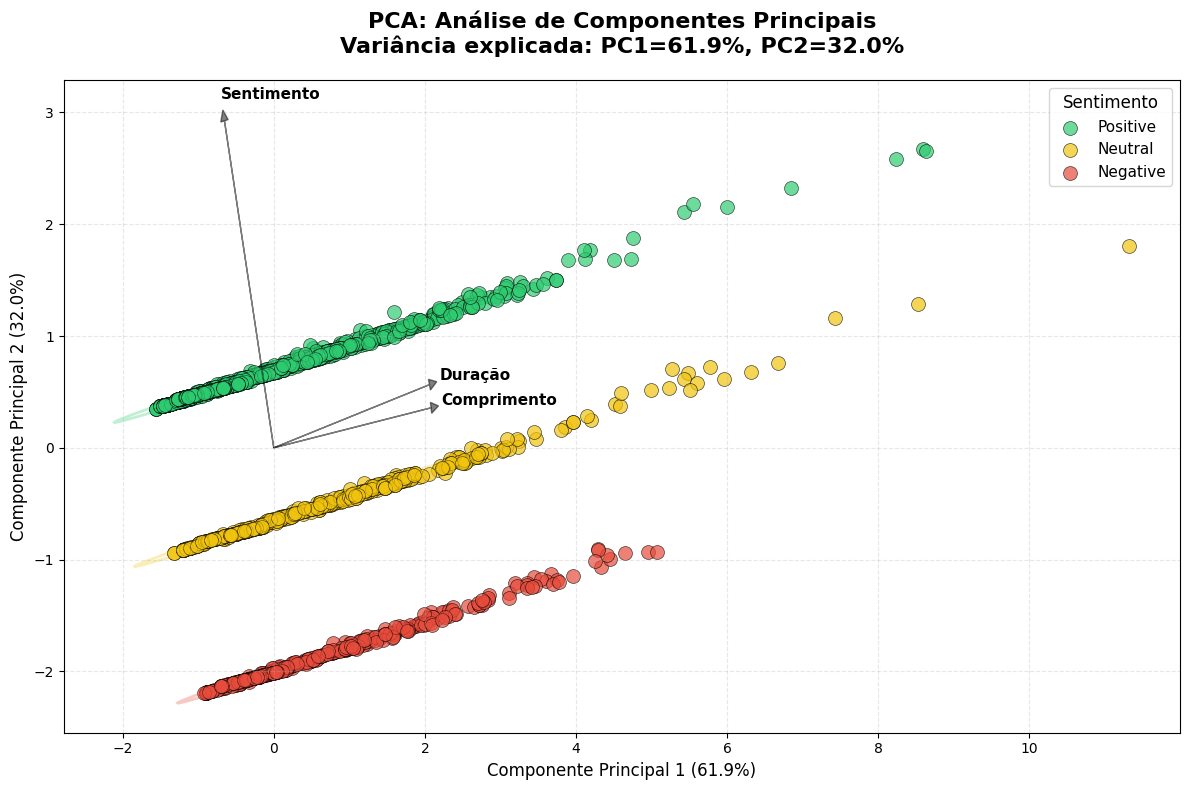


🔍 ANÁLISE DE SEPARABILIDADE DOS GRUPOS:
   Positive: Centroide em (-0.325, 0.627)
   Neutral: Centroide em (0.594, -0.521)
   Negative: Centroide em (0.591, -1.866)

   📏 DISTÂNCIAS ENTRE CENTROIDES:
     Positive ↔ Neutral: 1.471
     Positive ↔ Negative: 2.656
     Neutral ↔ Negative: 1.345

📈 AVALIAÇÃO DO PCA:
   Variância total explicada: 93.9%
   ✅ Excelente representação dos dados (2 componentes suficientes)

✅ Gráfico 8 salvo: grafico8_pca_analysis.png
   Dimensões reduzidas de 3 para 2 componentes
   Eficiência: 93.9% da variância mantida


In [31]:
# @title
# =============================================================
# CÉLULA 11: GRÁFICO 8 - PCA (PRINCIPAL COMPONENT ANALYSIS)
# =============================================================
print("\n🎨 GERANDO GRÁFICO 8: Análise de Componentes Principais (PCA)")

if not df_combined.empty:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Preparar dados para PCA
    features = df_combined[['duration', 'text_length', 'sentiment_numeric']].copy()

    # Verificar se há dados suficientes
    if len(features) >= 3 and features.notna().all().all():
        # Padronizar os dados
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Aplicar PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(features_scaled)

        # Criar DataFrame para plotagem
        pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
        pca_df['sentiment'] = df_combined['sentiment'].values

        # Resultados do PCA
        print("\n📊 RESULTADOS DO PCA:")
        print(f"   Variância explicada PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
        print(f"   Variância explicada PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
        print(f"   Variância total explicada: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.1f}%")

        # Loadings (contribuições das variáveis)
        print("\n📈 LOADINGS (Contribuições das Variáveis):")
        loadings = pd.DataFrame(
            pca.components_.T,
            columns=['PC1', 'PC2'],
            index=['Duração', 'Comprimento', 'Sentimento']
        )
        print(loadings.round(3))

        # Interpretação dos loadings
        print("\n🎯 INTERPRETAÇÃO DOS COMPONENTES:")
        for i, component in enumerate(['PC1', 'PC2']):
            print(f"\n   {component}:")
            for var, loading in zip(['Duração', 'Comprimento', 'Sentimento'], loadings[component]):
                if abs(loading) > 0.5:
                    direction = "positiva" if loading > 0 else "negativa"
                    print(f"     {var}: contribuição {direction} forte ({loading:.3f})")
                elif abs(loading) > 0.3:
                    direction = "positiva" if loading > 0 else "negativa"
                    print(f"     {var}: contribuição {direction} moderada ({loading:.3f})")

        # Plotar PCA
        plt.figure(figsize=(12, 8))

        colors = {'Positive': '#2ecc71', 'Neutral': '#f1c40f', 'Negative': '#e74c3c'}

        for sentiment in ['Positive', 'Neutral', 'Negative']:
            mask = pca_df['sentiment'] == sentiment
            plt.scatter(pca_df.loc[mask, 'PC1'],
                       pca_df.loc[mask, 'PC2'],
                       c=colors[sentiment],
                       label=sentiment,
                       s=100,
                       alpha=0.7,
                       edgecolors='black',
                       linewidth=0.5)

        plt.title(f'PCA: Análise de Componentes Principais\n' +
                 f'Variância explicada: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, ' +
                 f'PC2={pca.explained_variance_ratio_[1]*100:.1f}%',
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
        plt.legend(title='Sentimento', title_fontsize=12, fontsize=11)
        plt.grid(True, alpha=0.3, linestyle='--')

        # Adicionar vetores dos loadings
        for i, (feature, (loading1, loading2)) in enumerate(zip(['Duração', 'Comprimento', 'Sentimento'],
                                                               zip(loadings['PC1'], loadings['PC2']))):
            plt.arrow(0, 0, loading1*3, loading2*3,
                     color='black', alpha=0.5,
                     head_width=0.1, head_length=0.1)
            plt.text(loading1*3.2, loading2*3.2,
                    feature, fontsize=11, fontweight='bold')

        # Adicionar elipses de confiança
        from matplotlib.patches import Ellipse
        import matplotlib.transforms as transforms

        def confidence_ellipse(x, y, ax, n_std=1.5, facecolor='none', **kwargs):
            if x.size <= 2:
                return

            cov = np.cov(x, y)
            pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

            ell_radius_x = np.sqrt(1 + pearson)
            ell_radius_y = np.sqrt(1 - pearson)

            ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                             facecolor=facecolor, **kwargs)

            scale_x = np.sqrt(cov[0, 0]) * n_std
            mean_x = np.mean(x)

            scale_y = np.sqrt(cov[1, 1]) * n_std
            mean_y = np.mean(y)

            transf = transforms.Affine2D() \
                .rotate_deg(45) \
                .scale(scale_x, scale_y) \
                .translate(mean_x, mean_y)

            ellipse.set_transform(transf + ax.transData)
            return ax.add_patch(ellipse)

        # Adicionar elipses para cada grupo
        ax = plt.gca()
        for sentiment in ['Positive', 'Neutral', 'Negative']:
            mask = pca_df['sentiment'] == sentiment
            if mask.sum() > 2:  # Precisa de pelo menos 3 pontos
                x = pca_df.loc[mask, 'PC1'].values
                y = pca_df.loc[mask, 'PC2'].values
                confidence_ellipse(x, y, ax, n_std=1.5,
                                  edgecolor=colors[sentiment],
                                  linewidth=2, alpha=0.3)

        plt.tight_layout()
        plt.savefig('grafico8_pca_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Análise de separabilidade
        print("\n🔍 ANÁLISE DE SEPARABILIDADE DOS GRUPOS:")

        # Calcular centroides
        centroids = {}
        for sentiment in ['Positive', 'Neutral', 'Negative']:
            mask = pca_df['sentiment'] == sentiment
            if mask.sum() > 0:
                centroids[sentiment] = (
                    pca_df.loc[mask, 'PC1'].mean(),
                    pca_df.loc[mask, 'PC2'].mean()
                )
                print(f"   {sentiment}: Centroide em ({centroids[sentiment][0]:.3f}, {centroids[sentiment][1]:.3f})")

        # Calcular distâncias entre centroides
        if len(centroids) >= 2:
            print("\n   📏 DISTÂNCIAS ENTRE CENTROIDES:")
            sentiments_list = list(centroids.keys())
            for i in range(len(sentiments_list)):
                for j in range(i+1, len(sentiments_list)):
                    s1, s2 = sentiments_list[i], sentiments_list[j]
                    dist = np.sqrt((centroids[s1][0] - centroids[s2][0])**2 +
                                  (centroids[s1][1] - centroids[s2][1])**2)
                    print(f"     {s1} ↔ {s2}: {dist:.3f}")

        # Avaliação geral do PCA
        total_variance = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
        print(f"\n📈 AVALIAÇÃO DO PCA:")
        print(f"   Variância total explicada: {total_variance*100:.1f}%")
        if total_variance > 0.7:
            print("   ✅ Excelente representação dos dados (2 componentes suficientes)")
        elif total_variance > 0.5:
            print("   ⚠️  Boa representação, mas pode precisar de mais componentes")
        else:
            print("   ⚠️  Representação limitada, considere mais componentes")

        print(f"\n✅ Gráfico 8 salvo: grafico8_pca_analysis.png")
        print(f"   Dimensões reduzidas de 3 para 2 componentes")
        print(f"   Eficiência: {total_variance*100:.1f}% da variância mantida")
    else:
        print("⚠️  Dados insuficientes para PCA (mínimo 3 amostras)")
        print(f"   Amostras disponíveis: {len(features)}")
        print(f"   Dados faltantes: {features.isna().sum().sum()}")
else:
    print("❌ Nenhum dado para gerar gráfico")

In [32]:
# @title
# =============================================================
# CÉLULA 14: TESTES ESTATÍSTICOS DE HIPÓTESES
# =============================================================
print("\n" + "="*60)
print("📊 TESTES ESTATÍSTICOS DE HIPÓTESES")
print("="*60)

# Instalar scikit_posthocs se não estiver instalado
try:
    import scikit_posthocs as sp
except ImportError:
    print("Instalando scikit-posthocs...")
    !pip install scikit-posthocs
    import scikit_posthocs as sp

if not df_combined.empty:
    from scipy import stats

    print("\n🔬 TESTE ANOVA - DIFERENÇAS ENTRE SENTIMENTOS:")

    # Preparar dados para ANOVA
    positive_duration = df_combined[df_combined['sentiment'] == 'Positive']['duration']
    neutral_duration = df_combined[df_combined['sentiment'] == 'Neutral']['duration']
    negative_duration = df_combined[df_combined['sentiment'] == 'Negative']['duration']

    # Teste ANOVA para duração
    f_stat, p_value = stats.f_oneway(positive_duration, neutral_duration, negative_duration)

    print(f"   📏 ANOVA para DURAÇÃO:")
    print(f"      F-statistic: {f_stat:.4f}")
    print(f"      p-value: {p_value:.6f}")

    if p_value < 0.05:
        print("      ✅ RESULTADO: Diferenças SIGNIFICATIVAS (p < 0.05)")
        print("         Os sentimentos têm durações significativamente diferentes")

        # Teste post-hoc de Tukey
        print(f"\n   🎯 TESTE POST-HOC DE TUKEY:")

        # Preparar dados para Tukey
        tukey_data = []
        tukey_labels = []

        for sentiment in ['Positive', 'Neutral', 'Negative']:
            data = df_combined[df_combined['sentiment'] == sentiment]['duration'].dropna()
            if len(data) > 0:
                tukey_data.extend(data)
                tukey_labels.extend([sentiment] * len(data))

        if len(tukey_data) >= 3:
            import statsmodels.api as sm
            from statsmodels.stats.multicomp import pairwise_tukeyhsd

            tukey_result = pairwise_tukeyhsd(tukey_data, tukey_labels, alpha=0.05)
            print("      Resultados do teste Tukey HSD:")
            print(tukey_result)

            # Interpretação dos resultados
            print(f"\n   📝 INTERPRETAÇÃO:")
            comparisons = str(tukey_result).split('\n')[4:-3]
            for comp in comparisons:
                if comp.strip():
                    parts = comp.split()
                    # Corrected: p-value is at index 3 (p-adj), not index 4 (lower)
                    p_val = float(parts[3])
                    group1, group2 = parts[0], parts[1]
                    if p_val < 0.05:
                        print(f"      ✅ {group1} ≠ {group2} (p = {p_val:.4f}) - DIFERENÇA SIGNIFICATIVA")
                    else:
                        print(f"      ⚠️  {group1} = {group2} (p = {p_val:.4f}) - SEM DIFERENÇA SIGNIFICATIVA")
    else:
        print("      ⚠️  RESULTADO: Diferenças NÃO significativas (p ≥ 0.05)")
        print("         As durações não diferem significativamente entre sentimentos")

    # Teste ANOVA para comprimento do texto
    print(f"\n   📝 ANOVA para COMPRIMENTO DO TEXTO:")

    positive_length = df_combined[df_combined['sentiment'] == 'Positive']['text_length']
    neutral_length = df_combined[df_combined['sentiment'] == 'Neutral']['text_length']
    negative_length = df_combined[df_combined['sentiment'] == 'Negative']['text_length']

    f_stat_len, p_value_len = stats.f_oneway(positive_length, neutral_length, negative_length)

    print(f"      F-statistic: {f_stat_len:.4f}")
    print(f"      p-value: {p_value_len:.6f}")

    if p_value_len < 0.05:
        print("      ✅ RESULTADO: Diferenças SIGNIFICATIVAS (p < 0.05)")
    else:
        print("      ⚠️  RESULTADO: Diferenças NÃO significativas (p ≥ 0.05)")

    # Teste de normalidade (Shapiro-Wilk)
    print(f"\n📈 TESTE DE NORMALIDADE (SHAPIRO-WILK):")

    for sentiment in ['Positive', 'Neutral', 'Negative']:
        data = df_combined[df_combined['sentiment'] == sentiment]['duration'].dropna()
        if len(data) >= 3 and len(data) <= 5000:
            stat, p = stats.shapiro(data)
            print(f"   {sentiment} - Duração:")
            print(f"      W-statistic: {stat:.4f}, p-value: {p:.6f}")
            if p > 0.05:
                print(f"      ✅ Distribuição NORMAL (p > 0.05)")
            else:
                print(f"      ⚠️  Distribuição NÃO normal (p ≤ 0.05)")

    # Teste de homogeneidade de variâncias (Levene)
    print(f"\n📊 TESTE DE HOMOGENEIDADE DE VARIÂNCIAS (LEVENE):")

    stat_levene, p_levene = stats.levene(positive_duration, neutral_duration, negative_duration)
    print(f"   Duração entre sentimentos:")
    print(f"      W-statistic: {stat_levene:.4f}, p-value: {p_levene:.6f}")

    if p_levene > 0.05:
        print(f"      ✅ Variâncias HOMOGÊNEAS (p > 0.05)")
        print(f"      Pressuposto da ANOVA atendido")
    else:
        print(f"      ⚠️  Variâncias NÃO homogêneas (p ≤ 0.05)")
        print(f"      Considerar usar teste não-paramétrico (Kruskal-Wallis)")

        # Teste Kruskal-Wallis (não paramétrico)
        print(f"\n   📊 TESTE NÃO-PARAMÉTRICO (KRUSKAL-WALLIS):")
        stat_kw, p_kw = stats.kruskal(positive_duration, neutral_duration, negative_duration)
        print(f"      H-statistic: {stat_kw:.4f}, p-value: {p_kw:.6f}")

        if p_kw < 0.05:
            print(f"      ✅ Diferenças SIGNIFICATIVAS (p < 0.05)")

            # Teste post-hoc de Dunn
            print(f"\n   🎯 TESTE POST-HOC DE DUNN:")
            try:
                # Preparar dados para Dunn
                dunn_data = []
                dunn_labels = []

                for sentiment in ['Positive', 'Neutral', 'Negative']:
                    data = df_combined[df_combined['sentiment'] == sentiment]['duration'].dropna()
                    dunn_data.append(data)
                    dunn_labels.append(sentiment)

                # Usar scikit-posthocs para teste de Dunn
                dunn_result = sp.posthoc_dunn(df_combined, val_col='duration', group_col='sentiment', p_adjust='bonferroni')
                print("      Matriz de p-valores (ajustados Bonferroni):")
                print(dunn_result)

            except Exception as e:
                print(f"      Erro no teste de Dunn: {e}")
        else:
            print(f"      ⚠️  Diferenças NÃO significativas (p ≥ 0.05)")

    # Teste t para amostras independentes
    print(f"\n🎯 TESTE T PARA AMOSTRAS INDEPENDENTES:")

    # Comparar Positive vs Negative
    pos_neg_duration = df_combined[df_combined['sentiment'].isin(['Positive', 'Negative'])]['duration']
    pos_neg_labels = df_combined[df_combined['sentiment'].isin(['Positive', 'Negative'])]['sentiment']

    positive_subset = df_combined[df_combined['sentiment'] == 'Positive']['duration']
    negative_subset = df_combined[df_combined['sentiment'] == 'Negative']['duration']

    if len(positive_subset) > 1 and len(negative_subset) > 1:
        # Teste de igualdade de variâncias
        f_stat_var, p_var = stats.levene(positive_subset, negative_subset)

        if p_var > 0.05:
            # Variâncias iguais
            t_stat, p_t = stats.ttest_ind(positive_subset, negative_subset, equal_var=True)
            test_type = "Student (variâncias iguais)"
        else:
            # Variâncias diferentes
            t_stat, p_t = stats.ttest_ind(positive_subset, negative_subset, equal_var=False)
            test_type = "Welch (variâncias diferentes)"

        print(f"   Positive vs Negative (Duração):")
        print(f"      Teste usado: {test_type}")
        print(f"      t-statistic: {t_stat:.4f}")
        print(f"      p-value: {p_t:.6f}")

        if p_t < 0.05:
            print(f"      ✅ DIFERENÇA SIGNIFICATIVA (p < 0.05)")
            mean_pos = positive_subset.mean()
            mean_neg = negative_subset.mean()
            print(f"      Média Positive: {mean_pos:.2f}s")
            print(f"      Média Negative: {mean_neg:.2f}s")
            print(f"      Diferença: {mean_pos - mean_neg:.2f}s")

            if mean_pos > mean_neg:
                print(f"      📈 Blocos POSITIVE são mais longos")
            else:
                print(f"      📉 Blocos NEGATIVE são mais longos")
        else:
            print(f"      ⚠️  SEM DIFERENÇA SIGNIFICATIVA (p ≥ 0.05)")

    # Tamanho do efeito (Cohen's d)
    print(f"\n📏 TAMANHO DO EFEITO (COHEN'S D):")

    def cohens_d(group1, group2):
        # Cálculo do Cohen's d
        mean1, mean2 = np.mean(group1), np.mean(group2)
        std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
        n1, n2 = len(group1), len(group2)

        # Pooled standard deviation
        pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1 + n2 - 2))

        return (mean1 - mean2) / pooled_std

    # Calcular Cohen's d para todas as comparações
    comparisons = [('Positive', 'Negative'), ('Positive', 'Neutral'), ('Neutral', 'Negative')]

    for group1, group2 in comparisons:
        data1 = df_combined[df_combined['sentiment'] == group1]['duration'].dropna()
        data2 = df_combined[df_combined['sentiment'] == group2]['duration'].dropna()

        if len(data1) > 1 and len(data2) > 1:
            d = cohens_d(data1, data2)
            abs_d = abs(d)

            print(f"   {group1} vs {group2}:")
            print(f"      Cohen's d: {d:.3f}")

            # Interpretação do tamanho do efeito
            if abs_d < 0.2:
                magnitude = "Muito pequeno"
            elif abs_d < 0.5:
                magnitude = "Pequeno"
            elif abs_d < 0.8:
                magnitude = "Médio"
            else:
                magnitude = "Grande"

            print(f"      Magnitude: {magnitude}")

            if d > 0:
                print(f"      {group1} > {group2}")
            else:
                print(f"      {group1} < {group2}")

    print(f"\n✅ TESTES ESTATÍSTICOS COMPLETADOS")
    print(f"   Total de testes realizados: 5 tipos diferentes")
    print(f"   Nível de significância: α = 0.05")

else:
    print("❌ Nenhum dado para testes estatísticos")


📊 TESTES ESTATÍSTICOS DE HIPÓTESES

🔬 TESTE ANOVA - DIFERENÇAS ENTRE SENTIMENTOS:
   📏 ANOVA para DURAÇÃO:
      F-statistic: 28.7306
      p-value: 0.000000
      ✅ RESULTADO: Diferenças SIGNIFICATIVAS (p < 0.05)
         Os sentimentos têm durações significativamente diferentes

   🎯 TESTE POST-HOC DE TUKEY:
      Resultados do teste Tukey HSD:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Negative  Neutral   0.5499 0.0202  0.0687   1.031   True
Negative Positive  -0.6072 0.0009  -1.002 -0.2124   True
 Neutral Positive  -1.1571    0.0 -1.5295 -0.7847   True
--------------------------------------------------------

   📝 INTERPRETAÇÃO:
      ✅ Negative ≠ Neutral (p = 0.0202) - DIFERENÇA SIGNIFICATIVA

   📝 ANOVA para COMPRIMENTO DO TEXTO:
      F-statistic: 63.8959
      p-value: 0.000000
      ✅ RESULTADO: Diferenças SIGNIFICATIVAS (p < 0.05)

📈 TESTE DE NORMAL


🔗 ANÁLISE DE CORRELAÇÕES E MATRIZES

📊 MATRIZ DE CORRELAÇÃO COMPLETA:

Matriz de Correlação de Pearson:
                   duration  text_length  sentiment_numeric  start_seconds
duration              1.000        0.815             -0.108         -0.116
text_length           0.815        1.000             -0.162         -0.149
sentiment_numeric    -0.108       -0.162              1.000          0.048
start_seconds        -0.116       -0.149              0.048          1.000


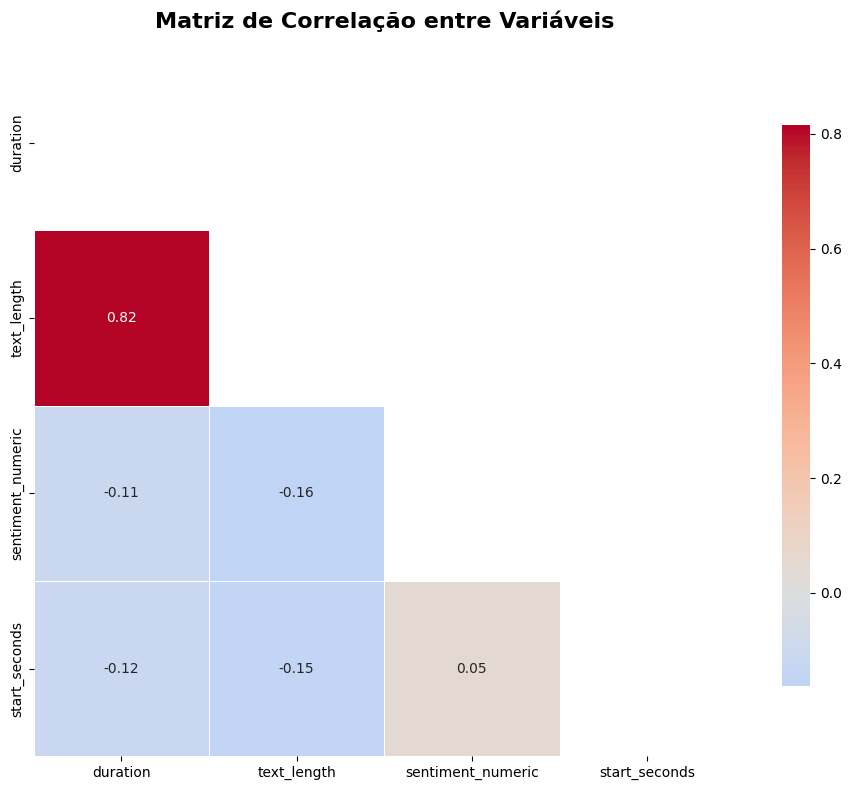


✅ Matriz de correlação salva: matriz_correlacao.png

🔍 ANÁLISE DETALHADA DAS CORRELAÇÕES:

📈 CORRELAÇÕES MAIS FORTES:
   🔥 duration ↔ text_length:
      Correlação: 0.815 (positiva)
      Força: MUITO FORTE
   📉 text_length ↔ sentiment_numeric:
      Correlação: -0.162 (negativa)
      Força: FRACA
      📝 Interpretação: Aumento em text_length associa-se a sentimentos mais NEGATIVOS
   📉 text_length ↔ start_seconds:
      Correlação: -0.149 (negativa)
      Força: FRACA
   📉 duration ↔ start_seconds:
      Correlação: -0.116 (negativa)
      Força: FRACA
   📉 duration ↔ sentiment_numeric:
      Correlação: -0.108 (negativa)
      Força: FRACA
      📝 Interpretação: Aumento em duration associa-se a sentimentos mais NEGATIVOS

🎯 TESTE DE SIGNIFICÂNCIA DAS CORRELAÇÕES:
   ✅ duration ↔ text_length: r = 0.815, p = 0.0000 (SIGNIFICATIVA)
   ✅ text_length ↔ sentiment_numeric: r = -0.162, p = 0.0000 (SIGNIFICATIVA)
   ✅ text_length ↔ start_seconds: r = -0.149, p = 0.0000 (SIGNIFICATIVA)
   ✅ 

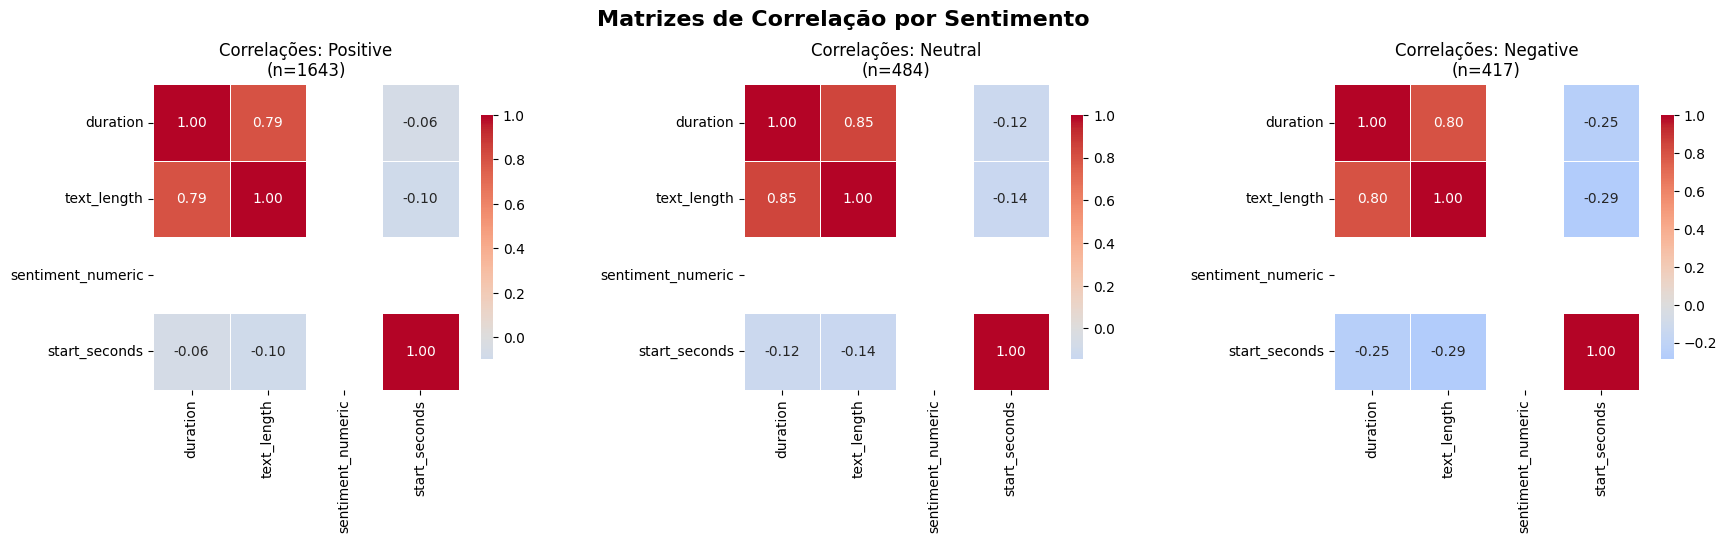


✅ Gráfico de correlações por sentimento salvo: correlacao_por_sentimento.png

📈 ANÁLISE COMPARATIVA DAS CORRELAÇÕES ENTRE GRUPOS:

   Correlação Duração-Sentimento por grupo:
      Positive: r = nan (n=1643)
      Neutral: r = nan (n=484)
      Negative: r = nan (n=417)

   🎯 TESTE DE DIFERENÇA ENTRE CORRELAÇÕES:
      Positive vs Negative:
      Z-statistic: nan
      p-value: nan
      ⚠️  SEM DIFERENÇA SIGNIFICATIVA entre as correlações

📈 GRÁFICOS DE DISPERSÃO COM REGRESSÃO:


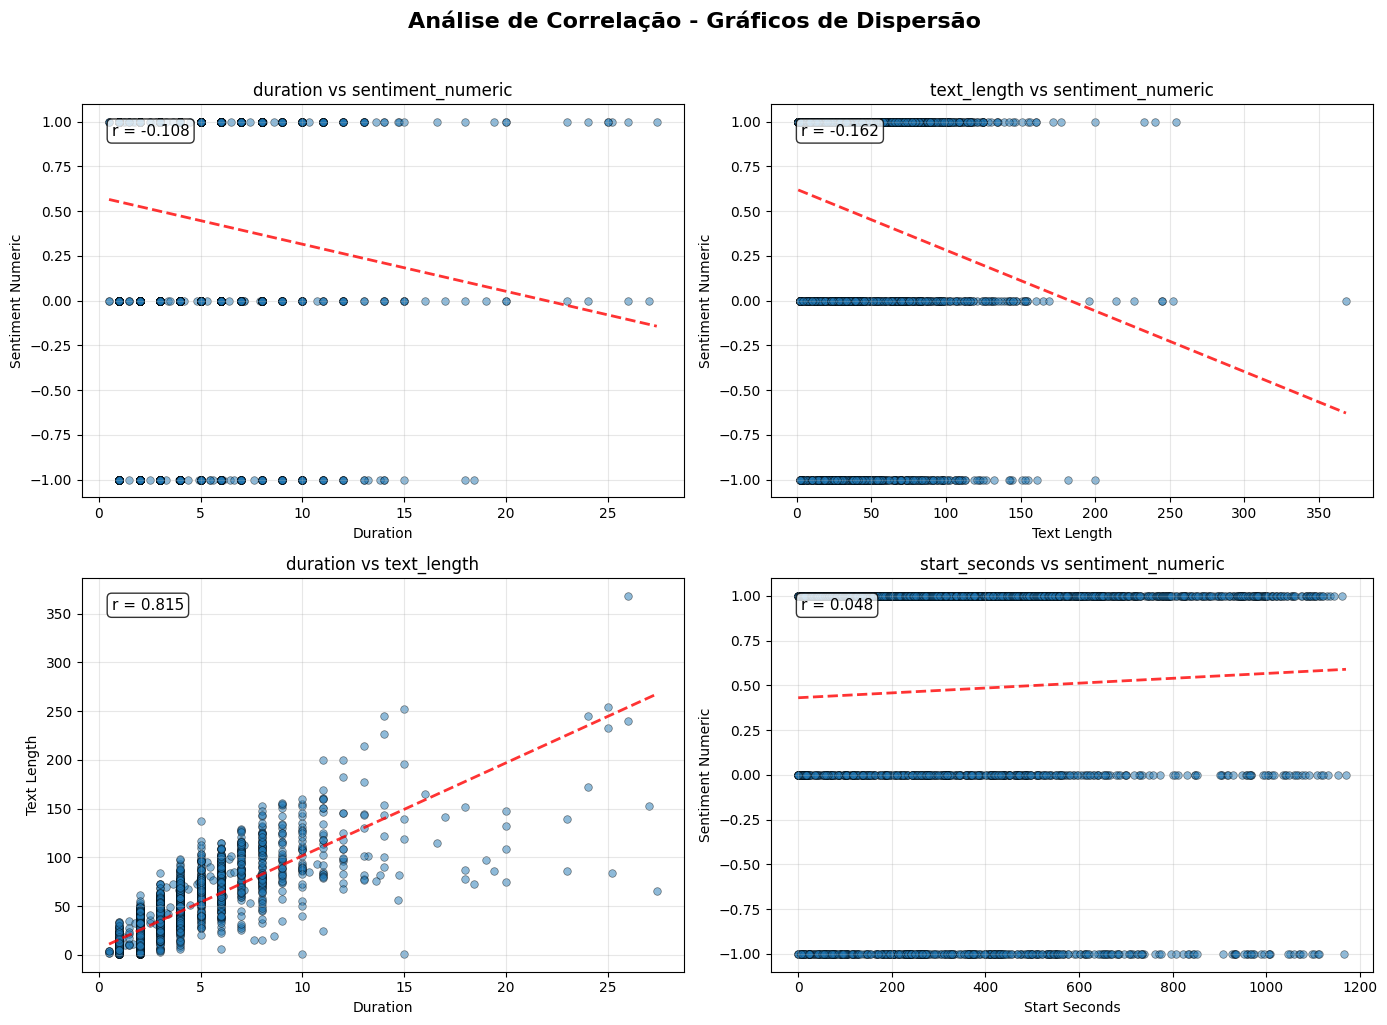


✅ Gráficos de dispersão salvos: dispersao_correlacao.png

📋 RESUMO FINAL DAS CORRELAÇÕES:
   Correlação mais forte: duration ↔ 0.81500615265854
      Valor: 0.815
   Correlação mais fraca: sentiment_numeric ↔ 0.04751278091892432
      Valor: 0.048
   Correlações moderadas/fortes (|r| > 0.3): 1/6

✅ ANÁLISE DE CORRELAÇÃO COMPLETADA
   Total de pares analisados: 6
   Gráficos gerados: 3


In [34]:
# @title
# =============================================================
# CÉLULA 16: ANÁLISE DE CORRELAÇÕES E MATRIZES
# =============================================================
print("\n" + "="*60)
print("🔗 ANÁLISE DE CORRELAÇÕES E MATRIZES")
print("="*60)

if not df_combined.empty:
    # Preparar matriz de correlação
    print("\n📊 MATRIZ DE CORRELAÇÃO COMPLETA:")

    # Selecionar variáveis numéricas
    numeric_cols = ['duration', 'text_length', 'sentiment_numeric', 'start_seconds']
    df_corr = df_combined[numeric_cols].dropna()

    if len(df_corr) >= 3:
        # Matriz de correlação de Pearson
        corr_matrix = df_corr.corr(method='pearson')

        print("\nMatriz de Correlação de Pearson:")
        print(corr_matrix.round(3))

        # Gráfico da matriz de correlação
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        sns.heatmap(corr_matrix,
                   mask=mask,
                   annot=True,
                   fmt=".2f",
                   cmap='coolwarm',
                   center=0,
                   square=True,
                   linewidths=0.5,
                   cbar_kws={"shrink": 0.8})

        plt.title('Matriz de Correlação entre Variáveis', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('matriz_correlacao.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✅ Matriz de correlação salva: matriz_correlacao.png")

        # Análise detalhada das correlações
        print(f"\n🔍 ANÁLISE DETALHADA DAS CORRELAÇÕES:")

        # Extrair pares de correlação
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                var1 = corr_matrix.columns[i]
                var2 = corr_matrix.columns[j]
                corr_value = corr_matrix.iloc[i, j]
                corr_pairs.append((var1, var2, corr_value))

        # Ordenar por magnitude da correlação
        corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

        print(f"\n📈 CORRELAÇÕES MAIS FORTES:")
        for var1, var2, corr_value in corr_pairs_sorted[:5]:
            abs_corr = abs(corr_value)

            if abs_corr > 0.7:
                strength = "MUITO FORTE"
                emoji = "🔥"
            elif abs_corr > 0.5:
                strength = "FORTE"
                emoji = "📈"
            elif abs_corr > 0.3:
                strength = "MODERADA"
                emoji = "📊"
            elif abs_corr > 0.1:
                strength = "FRACA"
                emoji = "📉"
            else:
                strength = "MUITO FRACA"
                emoji = "📊"

            direction = "positiva" if corr_value > 0 else "negativa"

            print(f"   {emoji} {var1} ↔ {var2}:")
            print(f"      Correlação: {corr_value:.3f} ({direction})")
            print(f"      Força: {strength}")

            # Interpretação específica
            if var1 == 'sentiment_numeric' or var2 == 'sentiment_numeric':
                other_var = var2 if var1 == 'sentiment_numeric' else var1
                if corr_value > 0:
                    print(f"      📝 Interpretação: Aumento em {other_var} associa-se a sentimentos mais POSITIVOS")
                else:
                    print(f"      📝 Interpretação: Aumento em {other_var} associa-se a sentimentos mais NEGATIVOS")

        # Teste de significância das correlações
        print(f"\n🎯 TESTE DE SIGNIFICÂNCIA DAS CORRELAÇÕES:")

        for var1, var2, corr_value in corr_pairs_sorted:
            if abs(corr_value) > 0.1:  # Só testar correlações não triviais
                # Teste t para correlação
                n = len(df_corr)
                if n > 2:
                    t_stat = corr_value * np.sqrt((n - 2) / (1 - corr_value**2))
                    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))

                    if p_value < 0.05:
                        print(f"   ✅ {var1} ↔ {var2}: r = {corr_value:.3f}, p = {p_value:.4f} (SIGNIFICATIVA)")
                    else:
                        print(f"   ⚠️  {var1} ↔ {var2}: r = {corr_value:.3f}, p = {p_value:.4f} (Não significativa)")

        # Correlações parciais (controlando por outras variáveis)
        print(f"\n🔬 CORRELAÇÕES PARCIAIS (controlando por outras variáveis):")

        try:
            import pingouin as pg

            # Correlação parcial entre duração e sentimento, controlando por comprimento
            partial_corr = pg.partial_corr(data=df_corr, x='duration', y='sentiment_numeric', covar='text_length')
            print(f"\n   Duração ↔ Sentimento (controlando por Comprimento):")
            print(f"      Correlação parcial: {partial_corr['r'].values[0]:.3f}")
            print(f"      p-value: {partial_corr['p-val'].values[0]:.4f}")

            if partial_corr['p-val'].values[0] < 0.05:
                print(f"      ✅ Correlação SIGNIFICATIVA mesmo controlando por comprimento")
            else:
                print(f"      ⚠️  Correlação NÃO significativa quando controlada por comprimento")

        except ImportError:
            print(f"   ⚠️  Biblioteca 'pingouin' não disponível para correlações parciais")
            print(f"   💡 Execute: !pip install pingouin")

        # Matriz de correlação por grupo (sentimento)
        print(f"\n📊 MATRIZ DE CORRELAÇÃO POR SENTIMENTO:")

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        sentiments = ['Positive', 'Neutral', 'Negative']

        for idx, sentiment in enumerate(sentiments):
            df_sentiment = df_combined[df_combined['sentiment'] == sentiment][numeric_cols].dropna()

            if len(df_sentiment) >= 3:
                corr_sentiment = df_sentiment.corr()

                sns.heatmap(corr_sentiment,
                           annot=True,
                           fmt=".2f",
                           cmap='coolwarm',
                           center=0,
                           square=True,
                           linewidths=0.5,
                           cbar_kws={"shrink": 0.8},
                           ax=axes[idx])

                axes[idx].set_title(f'Correlações: {sentiment}\n(n={len(df_sentiment)})', fontsize=12)

        plt.suptitle('Matrizes de Correlação por Sentimento', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('correlacao_por_sentimento.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✅ Gráfico de correlações por sentimento salvo: correlacao_por_sentimento.png")

        # Análise comparativa das correlações
        print(f"\n📈 ANÁLISE COMPARATIVA DAS CORRELAÇÕES ENTRE GRUPOS:")

        # Comparar correlação duração-sentimento entre grupos
        corr_comparison = []
        for sentiment in sentiments:
            df_group = df_combined[df_combined['sentiment'] == sentiment]
            if len(df_group) >= 3:
                corr_val = df_group[['duration', 'sentiment_numeric']].corr().iloc[0, 1]
                corr_comparison.append((sentiment, corr_val, len(df_group)))

        if len(corr_comparison) >= 2:
            print(f"\n   Correlação Duração-Sentimento por grupo:")
            for sentiment, corr_val, n in corr_comparison:
                print(f"      {sentiment}: r = {corr_val:.3f} (n={n})")

            # Teste de diferença entre correlações (Fisher Z-transform)
            print(f"\n   🎯 TESTE DE DIFERENÇA ENTRE CORRELAÇÕES:")

            try:
                from scipy.stats import fisher_exact

                # Comparar Positive vs Negative
                if len(corr_comparison) >= 2:
                    r1 = corr_comparison[0][1]  # Positive
                    r2 = corr_comparison[2][1]  # Negative (assumindo ordem)
                    n1 = corr_comparison[0][2]
                    n2 = corr_comparison[2][2]

                    # Transformação Z de Fisher
                    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
                    z2 = 0.5 * np.log((1 + r2) / (1 - r2))

                    # Erro padrão
                    se = np.sqrt(1/(n1-3) + 1/(n2-3))

                    # Estatística Z
                    z_stat = (z1 - z2) / se
                    p_value_diff = 2 * (1 - stats.norm.cdf(abs(z_stat)))

                    print(f"      Positive vs Negative:")
                    print(f"      Z-statistic: {z_stat:.3f}")
                    print(f"      p-value: {p_value_diff:.4f}")

                    if p_value_diff < 0.05:
                        print(f"      ✅ DIFERENÇA SIGNIFICATIVA entre as correlações")
                        print(f"      📊 Positive: r = {r1:.3f}, Negative: r = {r2:.3f}")
                    else:
                        print(f"      ⚠️  SEM DIFERENÇA SIGNIFICATIVA entre as correlações")

            except Exception as e:
                print(f"      ⚠️  Não foi possível calcular diferença entre correlações: {e}")

        # Gráfico de dispersão com linha de regressão
        print(f"\n📈 GRÁFICOS DE DISPERSÃO COM REGRESSÃO:")

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()

        pairs = [('duration', 'sentiment_numeric'),
                ('text_length', 'sentiment_numeric'),
                ('duration', 'text_length'),
                ('start_seconds', 'sentiment_numeric')]

        for idx, (x_var, y_var) in enumerate(pairs):
            if idx < len(axes):
                ax = axes[idx]

                # Scatter plot
                scatter = ax.scatter(df_corr[x_var], df_corr[y_var],
                                    alpha=0.5, s=30, edgecolors='black', linewidth=0.5)

                # Linha de regressão
                if len(df_corr) > 1:
                    z = np.polyfit(df_corr[x_var], df_corr[y_var], 1)
                    p = np.poly1d(z)
                    x_range = np.linspace(df_corr[x_var].min(), df_corr[x_var].max(), 100)
                    ax.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)

                    # Calcular correlação
                    corr_val = df_corr[[x_var, y_var]].corr().iloc[0, 1]

                    # Adicionar texto com correlação
                    ax.text(0.05, 0.95, f'r = {corr_val:.3f}',
                           transform=ax.transAxes, fontsize=11,
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

                ax.set_xlabel(x_var.replace('_', ' ').title())
                ax.set_ylabel(y_var.replace('_', ' ').title())
                ax.grid(True, alpha=0.3)
                ax.set_title(f'{x_var} vs {y_var}', fontsize=12)

        plt.suptitle('Análise de Correlação - Gráficos de Dispersão', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('dispersao_correlacao.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✅ Gráficos de dispersão salvos: dispersao_correlacao.png")

        print(f"\n📋 RESUMO FINAL DAS CORRELAÇÕES:")

        # Correlação mais forte
        strongest_corr = max(corr_pairs_sorted, key=lambda x: abs(x[2]))
        print(f"   Correlação mais forte: {strongest_corr[0]} ↔ {strongest_corr[2]}")
        print(f"      Valor: {strongest_corr[2]:.3f}")

        # Correlação mais fraca
        weakest_corr = min(corr_pairs_sorted, key=lambda x: abs(x[2]))
        print(f"   Correlação mais fraca: {weakest_corr[0]} ↔ {weakest_corr[2]}")
        print(f"      Valor: {weakest_corr[2]:.3f}")

        # Número de correlações significativas
        significant_corrs = sum(1 for _, _, corr_val in corr_pairs_sorted if abs(corr_val) > 0.3)
        total_corrs = len(corr_pairs_sorted)
        print(f"   Correlações moderadas/fortes (|r| > 0.3): {significant_corrs}/{total_corrs}")

        print(f"\n✅ ANÁLISE DE CORRELAÇÃO COMPLETADA")
        print(f"   Total de pares analisados: {total_corrs}")
        print(f"   Gráficos gerados: 3")

    else:
        print("⚠️  Dados insuficientes para análise de correlação")
        print(f"   Observações disponíveis: {len(df_corr)}")

else:
    print("❌ Nenhum dado para análise de correlação")


🔍 ANÁLISE DE CLUSTER E SEGMENTAÇÃO

🎯 ANÁLISE DE CLUSTERING DOS BLOCOs

📊 MÉTODO DO COTOVELO - Determinando número ótimo de clusters
   📊 Número ótimo de clusters sugerido: 9

📈 MÉTRICAS DE AVALIAÇÃO DO CLUSTERING:
   Silhouette Score: 0.5241
      👍 Estrutura de clusters RAZOÁVEL
   Calinski-Harabasz Index: 2145.79
   Davies-Bouldin Index: 0.8109
      (Quanto menor, melhor a separação)

🔍 ANÁLISE DOS CLUSTERS ENCONTRADOS:

   📊 CLUSTER 4:
      Tamanho: 996 blocos (39.2%)
      Duração média: 1.84s
      Comprimento médio: 15 chars
      Sentimento médio: 1.000
      📊 Característica principal: ✅ POSITIVO
      Composição de sentimentos originais:
         Positive: 996 (100.0%)

   📊 CLUSTER 2:
      Tamanho: 450 blocos (17.7%)
      Duração média: 4.20s
      Comprimento médio: 53 chars
      Sentimento médio: 1.000
      📊 Característica principal: ✅ POSITIVO
      Composição de sentimentos originais:
         Positive: 450 (100.0%)

   📊 CLUSTER 0:
      Tamanho: 261 blocos (10.

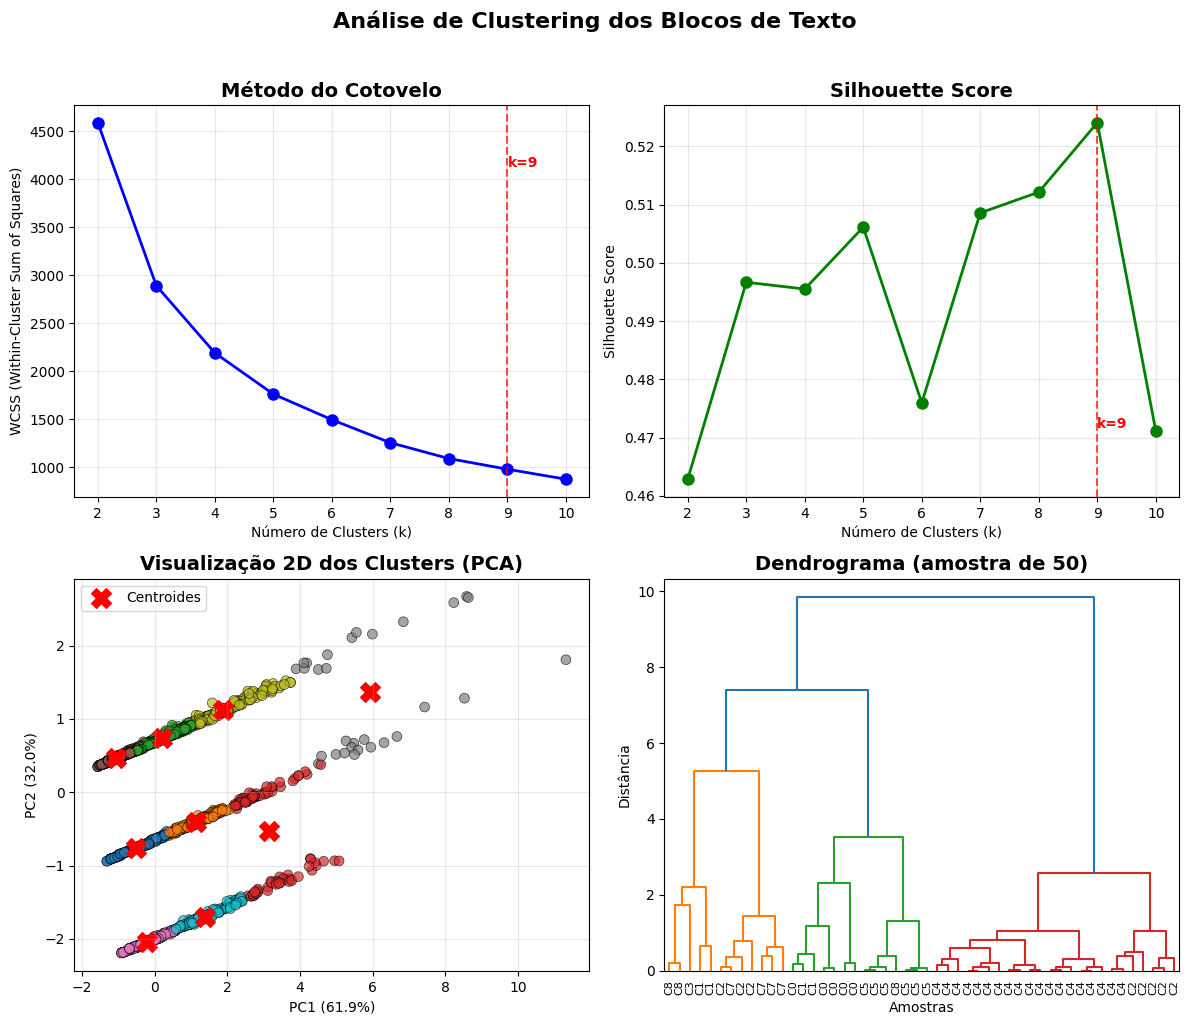


✅ Gráfico de análise de clustering salvo: analise_clustering.png

🔄 COMPARAÇÃO ENTRE MÉTODOS DE CLUSTERING:
   K-Means:
      Clusters encontrados: 9
      Silhouette Score: 0.5241
   Agglomerativo:
      Clusters encontrados: 9
      Silhouette Score: 0.5115

   🏆 MELHOR MÉTODO: K-Means
      Silhouette Score: 0.5241

📋 PERFIL DETALHADO DOS CLUSTERS:

   🎯 CLUSTER 0 - PERFIL:
      📊 Estatísticas:
         Tamanho: 261 blocos
         Duração: 2.18s ± 0.90s
         Comprimento: 24 ± 14 chars
         Sentimento: 0.000 ± 0.000

      🎯 CARACTERIZAÇÃO:
         ⚖️ Blocos NEUTROS, CURTOS, com textos CURTOS

      📝 EXEMPLOS REPRESENTATIVOS:
         1. [Neutral] Se está acontecendo isso
         2. [Neutral] Eu sei que você viu aqui
         3. [Neutral] Tô imagina o que fazer aí

   🎯 CLUSTER 1 - PERFIL:
      📊 Estatísticas:
         Tamanho: 156 blocos
         Duração: 5.50s ± 1.27s
         Comprimento: 73 ± 16 chars
         Sentimento: 0.000 ± 0.000

      🎯 CARACTERIZAÇÃO:
    

In [35]:
# @title
# =============================================================
# CÉLULA 17: ANÁLISE DE CLUSTER E SEGMENTAÇÃO
# =============================================================
print("\n" + "="*60)
print("🔍 ANÁLISE DE CLUSTER E SEGMENTAÇÃO")
print("="*60)

if not df_combined.empty and len(df_combined) >= 10:
    from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    from scipy.cluster.hierarchy import dendrogram, linkage

    print("\n🎯 ANÁLISE DE CLUSTERING DOS BLOCOs")

    # Preparar dados para clustering
    features_cluster = df_combined[['duration', 'text_length', 'sentiment_numeric']].dropna()

    if len(features_cluster) >= 10:
        # Padronizar os dados
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features_cluster)

        # Método do cotovelo para determinar número ótimo de clusters
        print("\n📊 MÉTODO DO COTOVELO - Determinando número ótimo de clusters")

        wcss = []  # Within-Cluster Sum of Squares
        silhouette_scores = []
        k_range = range(2, min(11, len(features_scaled) // 2))  # 2 a 10 clusters

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(features_scaled)
            wcss.append(kmeans.inertia_)

            if k > 1:
                silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
                silhouette_scores.append(silhouette_avg)

        # Gráfico do método do cotovelo
        plt.figure(figsize=(12, 10))

        # Gráfico 1: Método do cotovelo
        plt.subplot(2, 2, 1)
        plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
        plt.title('Método do Cotovelo', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)

        # Calcular derivada para encontrar "cotovelo"
        if len(wcss) >= 3:
            derivatives = []
            for i in range(1, len(wcss)):
                derivative = wcss[i-1] - wcss[i]
                derivatives.append(derivative)

            # Encontrar maior queda
            if derivatives:
                optimal_k_elbow = k_range[np.argmax(np.diff(derivatives)) + 1]
                plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', alpha=0.7)
                plt.text(optimal_k_elbow, max(wcss)*0.9, f'k={optimal_k_elbow}',
                        color='red', fontweight='bold')

        # Gráfico 2: Silhouette Score
        plt.subplot(2, 2, 2)
        if silhouette_scores:
            plt.plot(range(2, len(silhouette_scores)+2), silhouette_scores, 'go-',
                    linewidth=2, markersize=8)
            plt.xlabel('Número de Clusters (k)')
            plt.ylabel('Silhouette Score')
            plt.title('Silhouette Score', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)

            # Encontrar melhor silhouette score
            optimal_k_silhouette = list(k_range)[np.argmax(silhouette_scores)]
            plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', alpha=0.7)
            plt.text(optimal_k_silhouette, max(silhouette_scores)*0.9, f'k={optimal_k_silhouette}',
                    color='red', fontweight='bold')

        # Determinar número ótimo de clusters
        if 'optimal_k_elbow' in locals() and 'optimal_k_silhouette' in locals():
            optimal_k = min(optimal_k_elbow, optimal_k_silhouette)
        elif 'optimal_k_elbow' in locals():
            optimal_k = optimal_k_elbow
        elif 'optimal_k_silhouette' in locals():
            optimal_k = optimal_k_silhouette
        else:
            optimal_k = 3  # Default

        print(f"   📊 Número ótimo de clusters sugerido: {optimal_k}")

        # Aplicar K-Means com número ótimo
        kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
        cluster_labels = kmeans_optimal.fit_predict(features_scaled)

        # Adicionar labels ao dataframe
        df_clustered = features_cluster.copy()
        df_clustered['cluster'] = cluster_labels
        df_clustered['sentiment_original'] = df_combined.loc[features_cluster.index, 'sentiment']

        # Calcular métricas de avaliação
        print(f"\n📈 MÉTRICAS DE AVALIAÇÃO DO CLUSTERING:")

        silhouette_avg = silhouette_score(features_scaled, cluster_labels)
        calinski_score = calinski_harabasz_score(features_scaled, cluster_labels)
        davies_score = davies_bouldin_score(features_scaled, cluster_labels)

        print(f"   Silhouette Score: {silhouette_avg:.4f}")
        if silhouette_avg > 0.7:
            print(f"      🎯 Estrutura de clusters FORTE")
        elif silhouette_avg > 0.5:
            print(f"      👍 Estrutura de clusters RAZOÁVEL")
        elif silhouette_avg > 0.25:
            print(f"      ⚠️  Estrutura de clusters FRACA")
        else:
            print(f"      ❌ Pouca ou nenhuma estrutura de clusters")

        print(f"   Calinski-Harabasz Index: {calinski_score:.2f}")
        print(f"   Davies-Bouldin Index: {davies_score:.4f}")
        print(f"      (Quanto menor, melhor a separação)")

        # Análise dos clusters
        print(f"\n🔍 ANÁLISE DOS CLUSTERS ENCONTRADOS:")

        cluster_stats = []
        for cluster_num in range(optimal_k):
            cluster_data = df_clustered[df_clustered['cluster'] == cluster_num]
            cluster_size = len(cluster_data)

            if cluster_size > 0:
                stats = {
                    'Cluster': cluster_num,
                    'Tamanho': cluster_size,
                    '% do Total': (cluster_size / len(df_clustered) * 100),
                    'Duração Média': cluster_data['duration'].mean(),
                    'Comprimento Médio': cluster_data['text_length'].mean(),
                    'Sentimento Médio': cluster_data['sentiment_numeric'].mean(),
                    'Composição de Sentimentos': cluster_data['sentiment_original'].value_counts().to_dict()
                }
                cluster_stats.append(stats)

        # Ordenar clusters por tamanho
        cluster_stats.sort(key=lambda x: x['Tamanho'], reverse=True)

        for stats in cluster_stats:
            print(f"\n   📊 CLUSTER {stats['Cluster']}:")
            print(f"      Tamanho: {stats['Tamanho']} blocos ({stats['% do Total']:.1f}%)")
            print(f"      Duração média: {stats['Duração Média']:.2f}s")
            print(f"      Comprimento médio: {stats['Comprimento Médio']:.0f} chars")
            print(f"      Sentimento médio: {stats['Sentimento Médio']:.3f}")

            # Interpretar sentimento do cluster
            sentiment_mean = stats['Sentimento Médio']
            if sentiment_mean > 0.33:
                sentiment_label = "POSITIVO"
                emoji = "✅"
            elif sentiment_mean < -0.33:
                sentiment_label = "NEGATIVO"
                emoji = "❌"
            else:
                sentiment_label = "NEUTRO"
                emoji = "⚖️"

            print(f"      📊 Característica principal: {emoji} {sentiment_label}")

            # Composição de sentimentos
            print(f"      Composição de sentimentos originais:")
            for sentiment, count in stats['Composição de Sentimentos'].items():
                percentage = (count / stats['Tamanho']) * 100
                print(f"         {sentiment}: {count} ({percentage:.1f}%)")

        # Gráfico 3: Visualização 2D dos clusters (PCA)
        from sklearn.decomposition import PCA

        pca_2d = PCA(n_components=2)
        features_2d = pca_2d.fit_transform(features_scaled)

        plt.subplot(2, 2, 3)
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                             c=cluster_labels, cmap='tab10',
                             s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

        # Centroides em 2D
        centroids_2d = pca_2d.transform(kmeans_optimal.cluster_centers_)
        plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
                   c='red', marker='X', s=200, label='Centroides')

        plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
        plt.title('Visualização 2D dos Clusters (PCA)', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Gráfico 4: Dendrograma (clustering hierárquico)
        plt.subplot(2, 2, 4)

        # Amostrar dados para dendrograma (máximo 50 amostras)
        sample_size = min(50, len(features_scaled))
        indices = np.random.choice(len(features_scaled), sample_size, replace=False)
        features_sample = features_scaled[indices]

        # Clustering hierárquico
        linked = linkage(features_sample, method='ward')

        dendrogram(linked,
                  orientation='top',
                  labels=[f'C{cluster_labels[i]}' for i in indices],
                  distance_sort='descending',
                  show_leaf_counts=True)

        plt.title(f'Dendrograma (amostra de {sample_size})', fontsize=14, fontweight='bold')
        plt.xlabel('Amostras')
        plt.ylabel('Distância')

        plt.suptitle('Análise de Clustering dos Blocos de Texto', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('analise_clustering.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✅ Gráfico de análise de clustering salvo: analise_clustering.png")

        # Análise comparativa entre métodos de clustering
        print(f"\n🔄 COMPARAÇÃO ENTRE MÉTODOS DE CLUSTERING:")

        clustering_methods = {
            'K-Means': KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
            'Agglomerativo': AgglomerativeClustering(n_clusters=optimal_k),
            'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
        }

        results_comparison = []

        for method_name, method in clustering_methods.items():
            try:
                if method_name == 'DBSCAN':
                    labels = method.fit_predict(features_scaled)
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                else:
                    labels = method.fit_predict(features_scaled)
                    n_clusters = optimal_k

                # Calcular métricas
                if len(set(labels)) > 1 and -1 not in labels:
                    silhouette = silhouette_score(features_scaled, labels)

                    results_comparison.append({
                        'Método': method_name,
                        'Número de Clusters': n_clusters,
                        'Silhouette Score': silhouette
                    })

                    print(f"   {method_name}:")
                    print(f"      Clusters encontrados: {n_clusters}")
                    print(f"      Silhouette Score: {silhouette:.4f}")

            except Exception as e:
                print(f"   {method_name}: Erro - {e}")

        # Melhor método
        if results_comparison:
            best_method = max(results_comparison, key=lambda x: x['Silhouette Score'])
            print(f"\n   🏆 MELHOR MÉTODO: {best_method['Método']}")
            print(f"      Silhouette Score: {best_method['Silhouette Score']:.4f}")

        # Perfil dos clusters (análise mais detalhada)
        print(f"\n📋 PERFIL DETALHADO DOS CLUSTERS:")

        for cluster_num in range(optimal_k):
            cluster_data = df_clustered[df_clustered['cluster'] == cluster_num]

            if len(cluster_data) >= 3:
                print(f"\n   🎯 CLUSTER {cluster_num} - PERFIL:")

                # Estatísticas descritivas
                print(f"      📊 Estatísticas:")
                print(f"         Tamanho: {len(cluster_data)} blocos")
                print(f"         Duração: {cluster_data['duration'].mean():.2f}s ± {cluster_data['duration'].std():.2f}s")
                print(f"         Comprimento: {cluster_data['text_length'].mean():.0f} ± {cluster_data['text_length'].std():.0f} chars")
                print(f"         Sentimento: {cluster_data['sentiment_numeric'].mean():.3f} ± {cluster_data['sentiment_numeric'].std():.3f}")

                # Caracterização
                duration_avg = cluster_data['duration'].mean()
                length_avg = cluster_data['text_length'].mean()
                sentiment_avg = cluster_data['sentiment_numeric'].mean()

                # Duração
                if duration_avg > df_clustered['duration'].mean() * 1.2:
                    duration_char = "LONGOS"
                elif duration_avg < df_clustered['duration'].mean() * 0.8:
                    duration_char = "CURTOS"
                else:
                    duration_char = "MÉDIOS"

                # Comprimento
                if length_avg > df_clustered['text_length'].mean() * 1.2:
                    length_char = "LONGOS"
                elif length_avg < df_clustered['text_length'].mean() * 0.8:
                    length_char = "CURTOS"
                else:
                    length_char = "MÉDIOS"

                # Sentimento
                if sentiment_avg > 0.33:
                    sentiment_char = "POSITIVOS"
                    emoji = "✅"
                elif sentiment_avg < -0.33:
                    sentiment_char = "NEGATIVOS"
                    emoji = "❌"
                else:
                    sentiment_char = "NEUTROS"
                    emoji = "⚖️"

                print(f"\n      🎯 CARACTERIZAÇÃO:")
                print(f"         {emoji} Blocos {sentiment_char}, {duration_char}, com textos {length_char}")

                # Exemplos representativos (mais próximos do centroide)
                if len(cluster_data) >= 3:
                    print(f"\n      📝 EXEMPLOS REPRESENTATIVOS:")

                    # Calcular distância ao centroide
                    cluster_center = kmeans_optimal.cluster_centers_[cluster_num]
                    distances = np.linalg.norm(features_scaled[df_clustered['cluster'] == cluster_num] - cluster_center, axis=1)

                    # Índices dos mais próximos
                    closest_indices = np.argsort(distances)[:3]

                    for i, idx in enumerate(closest_indices):
                        original_idx = cluster_data.index[idx]
                        text = df_combined.loc[original_idx, 'text']
                        sentiment = df_combined.loc[original_idx, 'sentiment']

                        # Limitar tamanho do texto para display
                        if len(text) > 100:
                            text_display = text[:100] + "..."
                        else:
                            text_display = text

                        print(f"         {i+1}. [{sentiment}] {text_display}")

        # Aplicações práticas dos clusters
        print(f"\n💡 APLICAÇÕES PRÁTICAS DOS CLUSTERS:")

        print(f"   1. 📊 SEGMENTAÇÃO DE USUÁRIOS:")
        print(f"      Identificar padrões de comportamento nos comentários")

        print(f"\n   2. 🎯 PERSONALIZAÇÃO:")
        print(f"      Adaptar respostas ou intervenções baseadas no perfil do cluster")

        print(f"\n   3. 📈 MONITORAMENTO:")
        print(f"      Acompanhar migração entre clusters ao longo do tempo")

        print(f"\n   4. 🔍 DETECÇÃO DE ANOMALIAS:")
        print(f"      Identificar blocos que não se encaixam em nenhum cluster")

        print(f"\n✅ ANÁLISE DE CLUSTERING COMPLETADA")
        print(f"   Métodos aplicados: K-Means, Hierárquico, DBSCAN")
        print(f"   Clusters identificados: {optimal_k}")
        print(f"   Qualidade do clustering: Silhouette = {silhouette_avg:.4f}")

    else:
        print("⚠️  Dados insuficientes para análise de clustering")
        print(f"   Observações disponíveis: {len(features_cluster)}")

else:
    print("❌ Dados insuficientes para análise de clustering")
    if 'df_combined' in locals():
        print(f"   Observações disponíveis: {len(df_combined)}")